In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import OrderedDict
import heapq
from Queue import PriorityQueue
from tqdm import tqdm
%matplotlib inline
import pylab,random,cPickle
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] =400
from copy import copy
import time
idx = pd.IndexSlice
from sklearn.metrics import r2_score,mean_squared_error,roc_auc_score, accuracy_score,roc_curve,auc, precision_recall_curve,average_precision_score
from scipy.stats import ranksums,rankdata,pearsonr,spearmanr,mannwhitneyu
from os.path import dirname, basename,join,exists
from os import makedirs,system,listdir,rmdir
from matplotlib.colors import ListedColormap
import multiprocessing as mp
#import dill
import cPickle
import glob
from utils import PopulationCoverage,PopulationCoverage2,PopulationCoverage3

In [2]:
Sp=pd.read_pickle('s-protein-subunits.pkl')
allpre=pd.read_pickle('../preprocess_len25_all_adapt.pkl')
objectives=pd.read_pickle('../AllEpitopeFeatures.pkl')
hap1=pd.read_pickle('../haplotype_frequency_marry.pkl')
hap2=pd.read_pickle('../haplotype_frequency_marry2.pkl')

In [3]:
pos={'RBD':[330,524],'NTD':[18,305],'FP':[816,855]}
def findsub(pr,Sp,sb=None):
    if sb:
        rb=objectives[(objectives['protein']==pr)&(objectives['start_pos']>=pos[sb][0])&((objectives['start_pos']+objectives['epi_len'])<=pos[sb][1])].copy()
    else:
        rb=objectives[(objectives['protein']==pr)]
    print pr,sb,(rb['start_pos']+rb['epi_len']).max(),rb['start_pos'].min()
    length=(rb['start_pos']+rb['epi_len']).max()-rb['start_pos'].min()
    return length

sublen={}
for pr in ['S1','S2','M','N','E']:
    if pr=='S1':
        sublen[pr]=findsub(pr,Sp)
        for sb in ['RBD','NTD']:
            sublen[sb]=findsub(pr,Sp,sb)
    elif pr=='S2':
        sublen[pr]=findsub(pr,Sp)
        for sb in ['FP']:
            sublen[sb]=findsub(pr,Sp,sb)
    else:
        sublen[pr]=findsub(pr,Sp)
sublen['S1']=685
sublen['S']=sublen['S1']+sublen['S2']

S1 None 709 0
S1 RBD 524 330
S1 NTD 305 18
S2 None 1273 685
S2 FP 855 816
M None 222 0
N None 419 0
E None 75 0


In [4]:
def truncate(prediction,cutoff=0.6):
    return prediction.applymap(lambda x:0 if x<cutoff else x)
def binarize(prediction,cutoff,smaller=False):
    if smaller:
        return (prediction<=cutoff).applymap(lambda x:int(x))
    else:
        return (prediction>=cutoff).applymap(lambda x:int(x))
def gly(prediction,cutoff=0):
    prediction[objectives.loc[prediction.index]['glyco_probs']>cutoff]=0
    prediction[objectives.loc[prediction.index]['crosses_cleavage']>0]=0
    return prediction
import math
def ic2af(ic):
    if ic==0:
        return 0
    else:
        return 1-math.log(ic, 50000)
def af2ic(af):
    return 50000**(1-af)

## Reproducing figure 1A and figure S1 from precomputed result file
For source code that produced the result file, see the later part of this notebook.

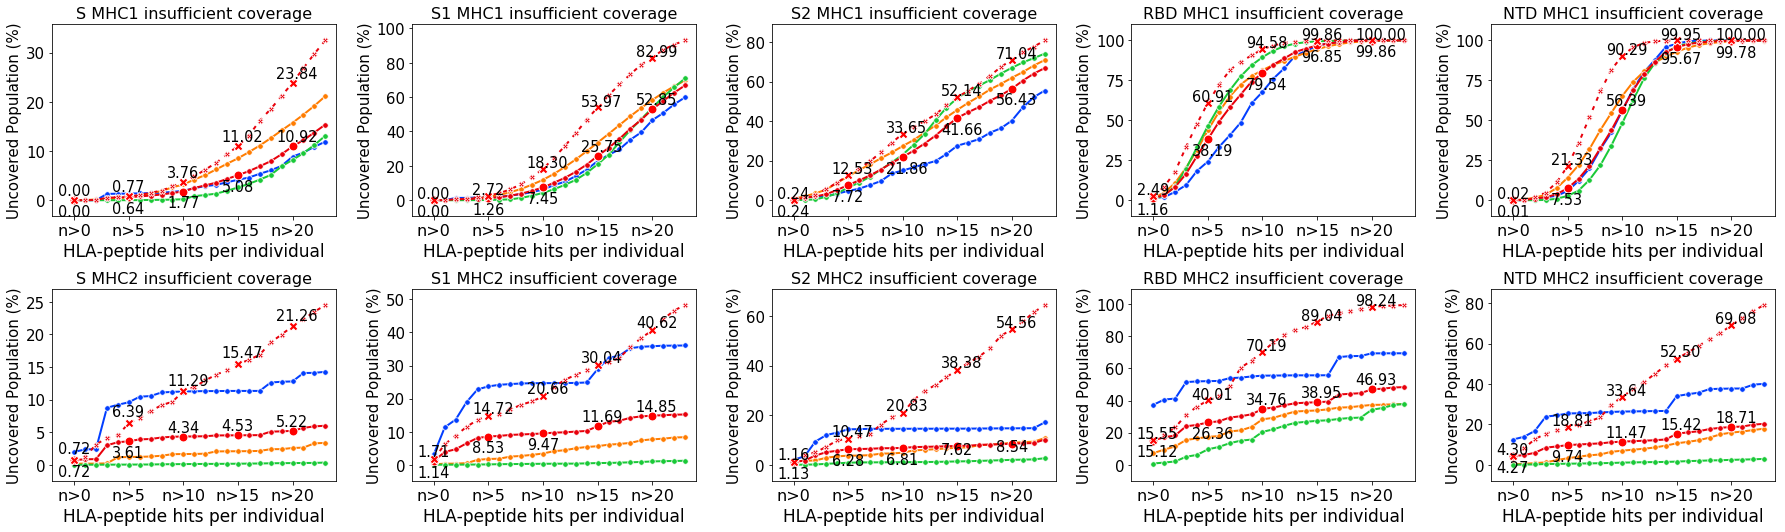

In [10]:
#this is the final cell system version
curve_subunit=pd.read_pickle('population_curves/evaluation_subunit_population_gap.pkl')
curve0=curve_subunit[curve_subunit['model'].apply(lambda x:x in ['MHC1_mhcflurry2.0-netmhc4.0-puffin-ensemble-affinity','MHC2_netmhc4.0-affinity'])]
f,axs=plt.subplots(2,5,figsize=(25,7.5))
count=0
for mhc in ['MHC1','MHC2']:
    for sub in ['S','S1','S2','RBD','NTD']:
        i=count//5
        j=count%5
        #case=sub+'_'+mhc
        with sns.color_palette("bright"):
            data=curve0[(curve0['subunit']==sub)&(curve0['num. augment peptides']==0)&(curve0['mhc']==mhc)]
            data=data[(data['task']=='All-windows')|((data['task']=='Non-redundant')&(data['ethnic']=='Average'))]
            data["population"]=data["population"]*100.0
            ax = sns.lineplot(x="cutoff", y="population",hue='ethnic',style='task',dashes=['',(2,3)],\
                              markers=['o','X'],markersize=5.5,linewidth=2,data=data,ax=axs[i][j])#markers=['o','X'],markersize=6,
            maxval=data['population'].max()
            ys1=[]
            ys2=[]
            for xx in [0,5,10,15,20]:
                y1=data[(data['cutoff']==xx)&(data['task']=='All-windows')&(data['ethnic']=='Average')]['population'].iloc[0]
                y2=data[(data['cutoff']==xx)&(data['task']=='Non-redundant')&(data['ethnic']=='Average')]['population'].iloc[0]
                ys1.append(y1)
                ys2.append(y2)
                if (y2-y1)/maxval<=0.25:
                    d2=-0.1*maxval
                elif sub=='S2':
                    d2=-0.05*maxval
                else:
                    d2=0.03*maxval
                ax.text(xx-1.5, y1+d2, '{:.2f}'.format(y1), fontsize=14.5,zorder=101)
                ax.text(xx-1.5, y2+1, '{:.2f}'.format(y2), fontsize=14.5,zorder=101)
            ax.scatter(x=[0,5,10,15,20],y=ys1,marker='o',s=80,c='r',edgecolors='white',zorder=100)
            ax.scatter(x=[0,5,10,15,20],y=ys2,marker='X',s=80,c='r',edgecolors='white',zorder=100)
            ax.set_xlim(-2,24)
            ax.set_ylim(-maxval*0.1,maxval*1.1)
            ax.set_xticks([0,5,10,15,20])
            ax.set_xticklabels(['n>{}'.format(y) for y in [0,5,10,15,20]],fontsize=16)
            ax.tick_params(axis='y', labelsize=15)
            ax.set_xlabel('HLA-peptide hits per individual',fontsize=17)
            ax.set_ylabel('Uncovered Population (%)',fontsize=15)
            ax.set_title('{} {} insufficient coverage'.format(sub,mhc),fontsize=16)# ({})'.format(st))
            ax.legend(framealpha=0.45,fontsize=10)
            ax.get_legend().remove()
        count+=1
plt.tight_layout()
plt.show()

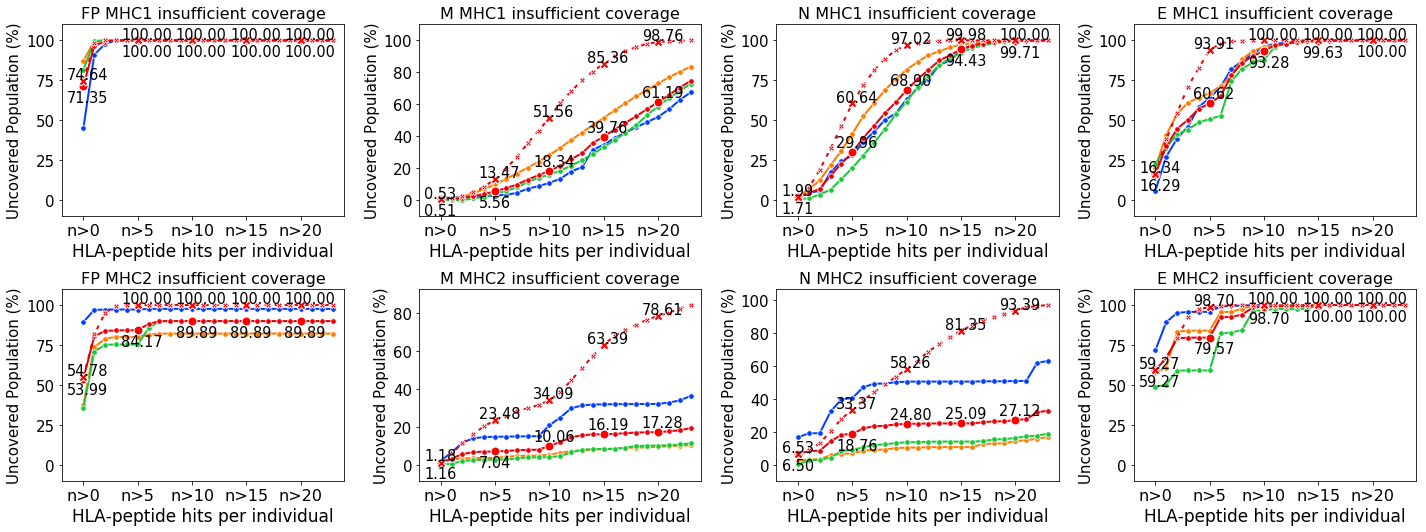

In [11]:
f,axs=plt.subplots(2,4,figsize=(20,7.5))
count=0
for mhc in ['MHC1','MHC2']:
    for sub in ['FP','M','N','E']:
        i=count//4
        j=count%4
        #case=sub+'_'+mhc
        with sns.color_palette("bright"):
            data=curve0[(curve0['subunit']==sub)&(curve0['num. augment peptides']==0)&(curve0['mhc']==mhc)]
            data=data[(data['task']=='All-windows')|((data['task']=='Non-redundant')&(data['ethnic']=='Average'))]
            data["population"]=data["population"]*100.0
            ax = sns.lineplot(x="cutoff", y="population",hue='ethnic',style='task',dashes=['',(2,3)],\
                              markers=['o','X'],markersize=5.5,linewidth=2,data=data,ax=axs[i][j])#markers=['o','X'],markersize=6,
            maxval=data['population'].max()
            ys1=[]
            ys2=[]
            for xx in [0,5,10,15,20]:
                y1=data[(data['cutoff']==xx)&(data['task']=='All-windows')&(data['ethnic']=='Average')]['population'].iloc[0]
                y2=data[(data['cutoff']==xx)&(data['task']=='Non-redundant')&(data['ethnic']=='Average')]['population'].iloc[0]
                ys1.append(y1)
                ys2.append(y2)
                if (y2-y1)/maxval<=0.25:
                    d2=-0.1*maxval
                elif sub=='S2':
                    d2=-0.05*maxval
                else:
                    d2=0.03*maxval
                ax.text(xx-1.5, y1+d2, '{:.2f}'.format(y1), fontsize=14.5,zorder=101)
                ax.text(xx-1.5, y2+1, '{:.2f}'.format(y2), fontsize=14.5,zorder=101)
            ax.scatter(x=[0,5,10,15,20],y=ys1,marker='o',s=80,c='r',edgecolors='white',zorder=100)
            ax.scatter(x=[0,5,10,15,20],y=ys2,marker='X',s=80,c='r',edgecolors='white',zorder=100)
            ax.set_xlim(-2,24)
            ax.set_ylim(-maxval*0.1,maxval*1.1)
            ax.set_xticks([0,5,10,15,20])
            ax.set_xticklabels(['n>{}'.format(y) for y in [0,5,10,15,20]],fontsize=16)
            ax.tick_params(axis='y', labelsize=15)
            ax.set_xlabel('HLA-peptide hits per individual',fontsize=17)
            ax.set_ylabel('Uncovered Population (%)',fontsize=15)
            ax.set_title('{} {} insufficient coverage'.format(sub,mhc),fontsize=16)# ({})'.format(st))
            ax.legend(framealpha=0.45,fontsize=10)
            ax.get_legend().remove()
        count+=1
plt.tight_layout()
plt.show()

## Reproducing figure 1B and C from precomputed result files
For source code that produced the result file, see the later part of this notebook.

In [12]:
curve_all=pd.read_pickle('population_curves/All_peptide_subunit_augmentation.pkl')
curve_adapt=pd.read_pickle('population_curves/MIRA_peptide_subunit_augmentation.pkl')
curve_all=curve_all[curve_all['model'].apply(lambda x:x in ['MHC1_netmhc4.1-puffin-ensemble-affinity','MHC2_netmhc4.0-EL-rank'])]
curve_adapt=curve_adapt[curve_adapt['model'].apply(lambda x:x in ['MHC1_mhcflurry2.0-netmhc4.0-puffin-ensemble-affinity','MHC2_netmhc4.0-affinity'])]

In [13]:
def findloc(compressed_curve,cut1=0.99,cut2=0.97,subs=['RBD','NTD','FP','M','N','E','S2','S1','S']):
    newbeamloc={}
    for case in subs:
        find=[]
        pt={}
        for mhc in ['MHC1','MHC2']:
            tmp=compressed_curve[(compressed_curve['cutoff']=='#hits$\leq$7')&(compressed_curve['ethnic']=='Average')&(compressed_curve['subunit']==case)&(compressed_curve['mhc']==mhc)]
            pt[mhc]=tmp[tmp['task']=='augmented_compress'].sort_values(by='num. augment peptides',ascending=False)
            #display(pt[mhc])
            if mhc[-1]=='1':
                cutoff1=pt[mhc].iloc[max(pt[mhc]['population'].searchsorted(1.0-cut1,side='right')-1,0)]['num. augment peptides']
            elif mhc[-1]=='2':
                cutoff1=pt[mhc].iloc[max(pt[mhc]['population'].searchsorted(1.0-cut2,side='right')-1,0)]['num. augment peptides']
            find.append(cutoff1)
        loc=max(find)
        p1=pt['MHC1'][pt['MHC1']['num. augment peptides']==loc]['population'].values[0]
        p2=pt['MHC2'][pt['MHC2']['num. augment peptides']==loc]['population'].values[0]
        #print case,len(pt[mhc]),loc,1-p1,1-p2
        newbeamloc[case]=[loc-1,loc,1-p1,1-p2]
    newbeamloc=pd.DataFrame(newbeamloc).transpose()
    newbeamloc.columns=['beam','#peptide','cutoff1','cutoff2']
    return newbeamloc

def findloc_single(compressed_curve,cut1=0.99,cut2=0.97,subs=['RBD','NTD','FP','M','N','E','S2','S1','S']):
    newbeamloc={}
    for case in subs:
        find=[]
        pt={}
        for mhc in ['MHC1','MHC2']:
            tmp=compressed_curve[(compressed_curve['cutoff']=='#hits$\leq$7')&(compressed_curve['ethnic']=='Average')&(compressed_curve['subunit']==case)&(compressed_curve['mhc']==mhc)]
            pt[mhc]=tmp[tmp['task']=='augmented_compress'].sort_values(by='num. augment peptides',ascending=False)
            #display(pt[mhc])
            if mhc[-1]=='1':
                cutoff1=pt[mhc].iloc[max(pt[mhc]['population'].searchsorted(1.0-cut1,side='right')-1,0)]['num. augment peptides']
            elif mhc[-1]=='2':
                cutoff1=pt[mhc].iloc[max(pt[mhc]['population'].searchsorted(1.0-cut2,side='right')-1,0)]['num. augment peptides']
            find.append(cutoff1)
        p1=pt['MHC1'][pt['MHC1']['num. augment peptides']==find[0]]['population'].values[0]
        p2=pt['MHC2'][pt['MHC2']['num. augment peptides']==find[1]]['population'].values[0]
        #print case,len(pt[mhc]),find[0],find[1],1-p1,1-p2
        newbeamloc[case]=[find[0],find[1],1-p1,1-p2]
    newbeamloc=pd.DataFrame(newbeamloc).transpose()
    newbeamloc.columns=['#peptide1','#peptide2','cutoff1','cutoff2']
    return newbeamloc

In [14]:
beamloc1=findloc_single(curve_all,0.993,0.98)
beam1_hi=findloc_single(curve_all,0.999,0.985)
beamloc1.loc[['S','S1']]=beam1_hi.loc[['S','S1']]
beamloc2=findloc_single(curve_adapt,0.993)
beam2_hi=findloc_single(curve_adapt,0.997)
beamloc2.loc[['S','S1']]=beam2_hi.loc[['S','S1']]
beamloc1.to_pickle('cutoff_multi_subunits_all.pkl')
beamloc2.to_pickle('cutoff_multi_subunits_adapt.pkl')
display(beamloc1),display(beamloc2)

,#peptide1,#peptide2,cutoff1,cutoff2
E,45.0,17.0,0.993052,0.986812
FP,48.0,13.0,0.993036,0.983382
M,30.0,15.0,0.993085,0.983096
N,38.0,5.0,0.993011,0.980580
NTD,33.0,12.0,0.993019,0.984462
RBD,37.0,12.0,0.993031,0.980177
S,24.0,1.0,0.999026,0.998986
S1,37.0,11.0,0.999059,0.987533
S2,33.0,12.0,0.993088,0.981242


,#peptide1,#peptide2,cutoff1,cutoff2
E,38.0,59.0,0.993261,0.858137
FP,41.0,36.0,0.993123,0.856913
M,26.0,35.0,0.993609,0.912388
N,32.0,23.0,0.993076,0.868853
NTD,29.0,59.0,0.993489,0.877513
RBD,30.0,34.0,0.993293,0.860178
S,17.0,20.0,0.998173,0.937114
S1,26.0,46.0,0.997198,0.894965
S2,24.0,24.0,0.993426,0.929726


(None, None)

In [15]:
vac1=pd.read_pickle('population_curves/adapt_joint_vaccein_curve.pkl')
vac2=pd.read_pickle('population_curves/adapt_independ_vaccine_curve.pkl')
vac2=vac2[vac2['model'].apply(lambda x:x in ['MHC2_netmhc4.0-affinity','MHC1_mhcflurry2.0-netmhc4.0-puffin-ensemble-affinity'])]
vac2['subunit']=vac2['subunit'].apply(lambda x:'all peptides' if x=='all' else 'MIRA peptides')
design=pd.concat([vac1,vac2],axis=0)
al=curve_all[(curve_all['task']=='augmented_full')&(curve_all['model']=='MHC1_mhcflurry2.0-netmhc4.0-puffin-ensemble-affinity')].copy()
al['candidate pool']='all peptides'
al2=curve_adapt[(curve_adapt['task']=='augmented_full')&(curve_adapt['model']=='MHC1_mhcflurry2.0-netmhc4.0-puffin-ensemble-affinity')].copy()
al2['candidate pool']='MIRA peptides'
al3=curve_all[(curve_all['task'].apply(lambda x:x in ['augmented_full','full']))&(curve_all['model']=='MHC2_netmhc4.0-affinity')].copy()
al3['candidate pool']='all peptides'
al4=curve_adapt[(curve_adapt['task'].apply(lambda x:x in ['augmented_full','full']))&(curve_adapt['model']=='MHC2_netmhc4.0-affinity')].copy()
al4['candidate pool']='MIRA peptides'
curve_aug=pd.concat([al,al2,al3,al4],axis=0)
vacloc=findloc_single(design,subs=design['subunit'].unique())
locs={'adapt':beamloc2,'all':beamloc1,'vaccine':vacloc}

/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Average


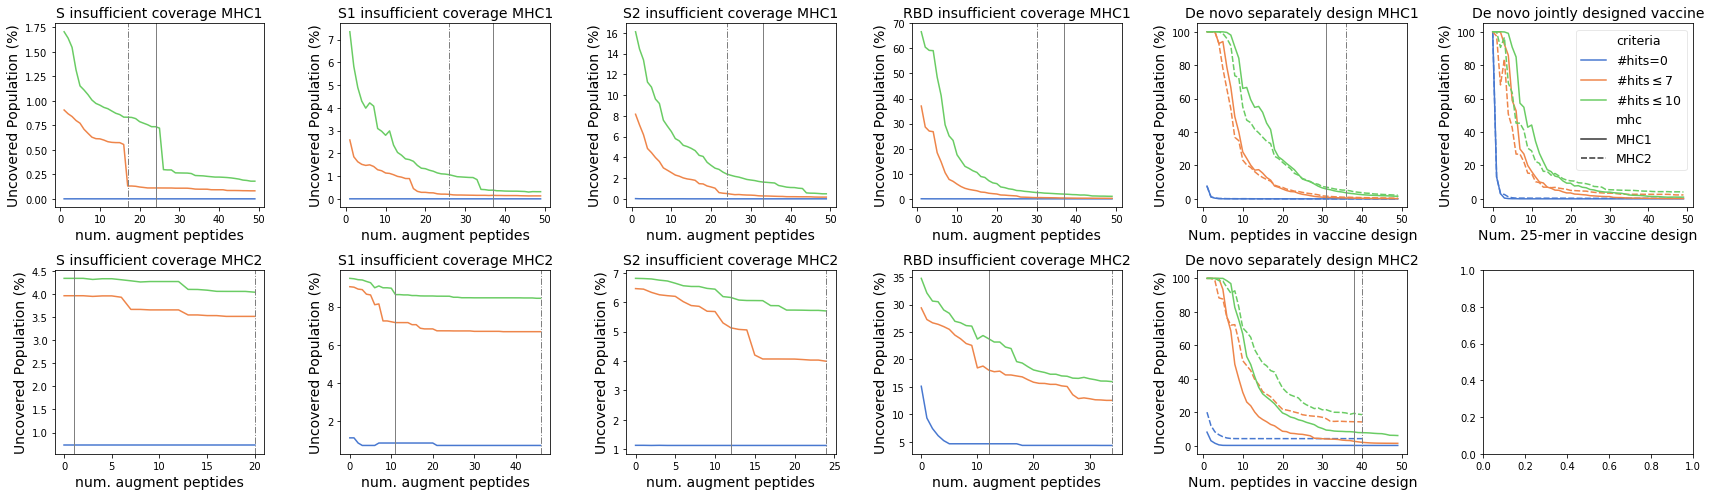

In [16]:
def plotmulti(curve_adapt,curve_design,cutloc,limit=50,task=['augmented_full','full'],groups=['Average'],style='candidate pool'):
    for st in groups:#,'Asian','Black','White']:
        f,axs=plt.subplots(2,6,figsize=(24,7))
        count=0
        print st
        for mhc in ['MHC1','MHC2']:
            for sub in ['S','S1','S2','RBD']:#,'FP','M','N','E''NTD',]:
                i=count//4
                j=count%4
                with sns.color_palette("muted"):
                    data=curve_adapt[(curve_adapt['mhc']==mhc)&(curve_adapt['subunit']==sub)&(curve_adapt['ethnic']==st)&(curve_adapt['task'].apply(lambda x:x in task))&(curve_adapt['num. augment peptides']<limit)]
                    data=data[data['cutoff'].apply(lambda x:x in ['#hits=0','#hits$\leq$7','#hits$\leq$10'])]
                    data['criteria']=data['cutoff']
                    data["population"]=data["population"]*100.0
                    ax = sns.lineplot(x="num. augment peptides", y="population",hue='criteria',style=style,data=data,ax=axs[i][j])
                    ax.axvline(x=cutloc['all']['#peptide'+mhc[-1]][sub],c='grey',ls='-',lw=1)
                    ax.axvline(x=cutloc['adapt']['#peptide'+mhc[-1]][sub],c='grey',ls='-.',lw=1)
                    ax.set_xlabel('num. augment peptides',fontsize=14)
                    ax.set_ylabel('Uncovered Population (%)',fontsize=14)
                    ax.set_title(sub+' insufficient coverage '+mhc,fontsize=14)# ({})'.format(st))
                    ax.legend(framealpha=0.45,fontsize=12.5)
                    ax.get_legend().remove()
                count+=1
        j=4
        i=0
        with sns.color_palette("muted"):
            for mhc in ['MHC1','MHC2']:
                data=curve_design[(curve_design['mhc']==mhc)&(curve_design['subunit']!='design')&(curve_design['ethnic']==st)&(curve_design['task']=='augmented_compress')&(curve_design['num. augment peptides']<50)]
                data=data[data['cutoff'].apply(lambda x:x in ['#hits=0','#hits$\leq$7','#hits$\leq$10'])]
                data['criteria']=data['cutoff']
                data["population"]=data["population"]*100.0
                #print data
                data['candidate pool']=data['subunit']
                ax = sns.lineplot(x="num. augment peptides", y="population",hue='criteria',style='candidate pool',style_order=['all peptides','MIRA peptides'],data=data,ax=axs[i][j])
                ax.axvline(x=cutloc['vaccine']['#peptide'+mhc[-1]]['all peptides'],c='grey',ls='-',lw=1)
                ax.axvline(x=cutloc['vaccine']['#peptide'+mhc[-1]]['MIRA peptides'],c='grey',ls='-.',lw=1)
                ax.set_xlabel('Num. peptides in vaccine design',fontsize=14)
                ax.set_ylabel('Uncovered Population (%)',fontsize=14)
                ax.set_title('De novo separately design '+mhc,fontsize=14)# ({})'.format(st))
                ax.legend(framealpha=0.45,fontsize=12.5)
                ax.get_legend().remove()
                i+=1
        i=0
        j=5
        with sns.color_palette("muted"): 
            data=curve_design[(curve_design['subunit']=='design')&(curve_design['ethnic']==st)&(curve_design['task']=='augmented_compress')&(curve_design['num. augment peptides']<50)]
            data=data[data['cutoff'].apply(lambda x:x in ['#hits=0','#hits$\leq$7','#hits$\leq$10'])]
            data['criteria']=data['cutoff']
            data["population"]=data["population"]*100.0
            ax = sns.lineplot(x="num. augment peptides", y="population",hue='criteria',style='mhc',data=data,ax=axs[i][j])
            #ax.axvline(x=cutloc['vaccine']['#peptide2']['design'],c='grey',ls='-',lw=1)
            ax.set_xlabel('Num. 25-mer in vaccine design',fontsize=14)
            ax.set_ylabel('Uncovered Population (%)',fontsize=14)
            ax.set_title('De novo jointly designed vaccine',fontsize=14)# ({})'.format(st))
            ax.legend(framealpha=0.45,fontsize=12.5)
            #ax.get_legend().remove()
        plt.tight_layout()
        plt.show()
plotmulti(curve_aug,design,locs)

## Calculating the result curve files

Download the prediction files `mhc2_haplotype_netmhcii-4.0-adapt_pred_affinity_pivot.pkl.gz` and `mhc1_haplotype_ensemb-adapt_pred_affinity_pivot.pkl.gz`, and the haplotype file `preprocess_haplotype_new1.pkl` and `preprocess_haplotype_new2.pkl` from [here](https://www.dropbox.com/sh/v1jcin4mh7jua14/AAB7W0Y7IXtXRL8Ehlrtvft6a?dl=0) and put them into the same directory before running the below commands.

In [5]:
dss={}
pcs={}
hap={'MHC1':hap1,'MHC2':hap2}
dss['MHC2_netmhc4.0-affinity']=pd.read_pickle('../mhc2_haplotype_netmhcii-4.0-adapt_pred_affinity_pivot.pkl.gz')
dss['MHC1_mhcflurry2.0-netmhc4.0-puffin-ensemble-affinity']=pd.read_pickle('../mhc1_haplotype_ensemb-adapt_pred_affinity_pivot.pkl.gz')
for key in dss:
    pcs[key]=PopulationCoverage3(dss[key],hap[key.split('_')[0]],['White','Black','Asians'])

None
None


In [6]:
keymap={'MHC1':[],'MHC2':[]}
for key in dss:
    mhc=key.split('_')[0]
    keymap[mhc].append(key)

In [7]:
def compute_probs(hist_detail):
    hist_all={'White':[],'Black':[],'Asians':[]}
    for j,cntry in enumerate(hist_detail):
        hist=hist_detail[cntry][1]
        for cut in range(40):
            hist_all[cntry].append(hist[hist['count']>cut]['freq'].sum())
    hist_all=pd.DataFrame(hist_all)
    hist_all['average']=hist_all.mean(axis=1)
    #display(hist_all)
    return hist_all

In [ ]:
# Estimating subunit population coverage for each genotypes, for both non-redundant and redundant representation. 
# Store results as basement for augmentation
if not exists('basements'):
    makedirs('basements')
for sub in ['RBD','NTD','FP','M','N','E','S2','S1','S']:
    for key in pcs:
        mhc=key.split('_')[0]
        pc0=pcs[key]
        print sub,key
        base_result=pc0.overall_coverage(epitopes=list(Sp[sub+'_'+mhc]),lower=0,verbose=True,pre_map=True,return_pre=True,typem='mhc{}_haplotype'.format(mhc[-1]))
        base_hist=compute_probs(base_result[1])
        pre_base=[]
        for cntry in ['White','Black','Asians']:
            pre_base.append(base_result[1][cntry][2])
        pre_base=pd.concat(pre_base,axis=0)
        basedir=join('basements/adapt_basement_full_{}_{}.pkl'.format(sub+'_'+mhc,key))
        pre_base.to_pickle(basedir)
        base_result=pc0.overall_coverage(epitopes=list(Sp['compressed_'+sub+'_'+mhc]),lower=0,verbose=True,pre_map=True,return_pre=True,typem='mhc{}_haplotype'.format(mhc[-1]))
        base_hist=compute_probs(base_result[1])
        pre_base=[]
        for cntry in ['White','Black','Asians']:
            pre_base.append(base_result[1][cntry][2])
        pre_base=pd.concat(pre_base,axis=0)
        basedir=join('basements/adapt_basement_compress_{}_{}.pkl'.format(sub+'_'+mhc,key))
        pre_base.to_pickle(basedir)

In [100]:
bdir='optimization_result/'
files={}
for sub in ['RBD','NTD','FP','M','N','E','S2','S1','S']:
    for mhc in ['MHC1','MHC2']:
        f='augment_{}_with_adaptive_mhc{}_normed40'.format(sub,mhc[-1])
        files[sub+'_'+mhc]=f
peptides_adapt={}#'final_hap_netmhc4.0_mhc2_pred_affinity_binary_l7_0.90_beam5_diverse5',\
for case in files:
    d=join(bdir,files[case])
    if exists(d):
        print d
    peptides_adapt[case]={}
    fs=glob.glob(join(d,'beam_*.p'))
    print case,len(fs)
    peptides_adapt[case][0]=[]
    for l in range(len(fs)):
        try:
            curr_beam=OrderedDict(cPickle.load(open(join(d,'beam_{}.p'.format(l)), "rb" )))
            peptides_adapt[case][l+1]=curr_beam.items()[0][0].split('_')
        except:
            print 'read error'
            pass

optimization_result/augment_RBD_with_adaptive_mhc1_normed40
RBD_MHC1 100
optimization_result/augment_NTD_with_adaptive_mhc2_normed40
NTD_MHC2 83
optimization_result/augment_NTD_with_adaptive_mhc1_normed40
NTD_MHC1 100
optimization_result/augment_RBD_with_adaptive_mhc2_normed40
RBD_MHC2 34
optimization_result/augment_S1_with_adaptive_mhc2_normed40
S1_MHC2 46
optimization_result/augment_E_with_adaptive_mhc1_normed40
E_MHC1 100
optimization_result/augment_E_with_adaptive_mhc2_normed40
E_MHC2 67
optimization_result/augment_S_with_adaptive_mhc2_normed40
S_MHC2 20
optimization_result/augment_FP_with_adaptive_mhc1_normed40
FP_MHC1 100
optimization_result/augment_FP_with_adaptive_mhc2_normed40
FP_MHC2 36
optimization_result/augment_S_with_adaptive_mhc1_normed40
S_MHC1 100
optimization_result/augment_M_with_adaptive_mhc1_normed40
M_MHC1 100
optimization_result/augment_M_with_adaptive_mhc2_normed40
M_MHC2 35
optimization_result/augment_S2_with_adaptive_mhc2_normed40
S2_MHC2 24
optimization_resul

In [244]:
bdir='optimization_result/'
files={}
for sub in ['RBD','NTD','FP','M','N','E','S2','S1','S']:
    for mhc in ['MHC1','MHC2']:
        f='augment_{}_with_all_mhc{}_normed40'.format(sub,mhc[-1])
        files[sub+'_'+mhc]=f
peptides_all={}#'final_hap_netmhc4.0_mhc2_pred_affinity_binary_l7_0.90_beam5_diverse5',\
for case in files:
    d=join(bdir,files[case])
    peptides_all[case]={}
    fs=glob.glob(join(d,'beam_*.p'))
    print case,len(fs)
    peptides_all[case][0]=[]
    for l in range(len(fs)):
        try:
            curr_beam=OrderedDict(cPickle.load(open(join(d,'beam_{}.p'.format(l)), "rb" )))
            peptides_all[case][l+1]=curr_beam.items()[0][0].split('_')
        except:
            print case,l,'read error'
            pass

RBD_MHC1 100
NTD_MHC2 94
NTD_MHC1 100
RBD_MHC2 90
S1_MHC2 97
E_MHC1 100
E_MHC2 87
S_MHC2 100
FP_MHC1 100
FP_MHC2 83
S_MHC1 100
M_MHC1 100
M_MHC2 94
S2_MHC2 100
S2_MHC1 100
S1_MHC1 100
N_MHC1 100
N_MHC2 89


In [21]:
#single task
def collect_result(result):
    results.append(result)
    
def loop2(inputs):
    case,progress,pc_bs,mhc,model,ls,oldrange=inputs
    curve=[]
    print case,ls[0],ls[-1]
    def extractuncover(rsb1):
        hist_all={'White':[],'Black':[],'Asian':[]}
        for cnt in ['White','Black','Asians']:
            hist=rsb1[1][cnt][1]
            for cut in range(25):
                if cnt=='Asians':
                    hist_all['Asian'].append(hist[hist['count']<=cut]['freq'].sum())
                else:
                    hist_all[cnt].append(hist[hist['count']<=cut]['freq'].sum())
        hist_all=pd.DataFrame(hist_all)
        hist_all['Average']=hist_all.mean(axis=1)
        hist_all.index=hist_all.index.rename('min_cutoff')
        #display(hist_all)
        return hist_all
    for l in ls:#range(min(50,len(progress))):
        print l
        if not l in oldrange:
            for method in ['full','compress']:
                if l==0:
                    title=method
                else:
                    title='augmented_'+method
                ba='basements/adapt_basement_{}_{}_{}'.format(method,case,model)+'.pkl'
                rs=pc_bs.overall_coverage(epitopes=progress[l],lower=0,\
                                                verbose=True,pre_map=True,return_pre=True,typem='{}_haplotype'.format('mhc'+mhc[-1]),base=ba)
                hist1=extractuncover(rs)
                for group in hist1:
                    curve.append((l,hist1[group].loc[0],'#hits=0',group,case.split('_')[0],title,mhc,model))
                    curve.append((l,hist1[group].loc[4],'#hits$\leq$4',group,case.split('_')[0],title,mhc,model))
                    curve.append((l,hist1[group].loc[5],'#hits$\leq$5',group,case.split('_')[0],title,mhc,model))
                    curve.append((l,hist1[group].loc[7],'#hits$\leq$7',group,case.split('_')[0],title,mhc,model))
                    curve.append((l,hist1[group].loc[10],'#hits$\leq$10',group,case.split('_')[0],title,mhc,model))
                    curve.append((l,hist1[group].loc[20],'#hits$\leq$20',group,case.split('_')[0],title,mhc,model))
    return pd.DataFrame(curve,columns=['num. augment peptides','population','cutoff','ethnic','subunit','task','mhc','model'])

def loop3(inputs):
    case,progress,pc_bs,mhc,model=inputs
    curve=[]
    def extractuncover(rsb1):
        hist_all={'White':[],'Black':[],'Asian':[]}
        for cnt in ['White','Black','Asians']:
            hist=rsb1[1][cnt][1]
            for cut in range(25):
                if cnt=='Asians':
                    hist_all['Asian'].append(hist[hist['count']<=cut]['freq'].sum())
                else:
                    hist_all[cnt].append(hist[hist['count']<=cut]['freq'].sum())
        hist_all=pd.DataFrame(hist_all)
        hist_all['Average']=hist_all.mean(axis=1)
        hist_all.index=hist_all.index.rename('min_cutoff')
        return hist_all
    tt={'full':'All-windows','compress':'Non-redundant'}
    for l in [0]:#range(min(50,len(progress))):
        for method in ['full','compress']:
            ba='basements/adapt_basement_{}_{}_{}'.format(method,case,model)+'.pkl'
            rs=pc_bs.overall_coverage(epitopes=list(progress[l]),lower=0,\
                                        verbose=True,pre_map=True,return_pre=True,typem='{}_haplotype'.format('mhc'+mhc[-1]),base=ba)
            hist1=extractuncover(rs)
            for group in hist1:
                for hit in range(24):
                    curve.append((l,hist1[group].loc[hit],hit,group,case.split('_')[0],tt[method],mhc,model))
    return pd.DataFrame(curve,columns=['num. augment peptides','population','cutoff','ethnic','subunit','task','mhc','model'])

In [ ]:
if not exists('reproduce_curves'):
    makedirs('reproduce_curves')

In [144]:
pool=pp._ProcessPool(processes=30)
all_args=[]
for case in peptides_adapt:
    mhc=case.split('_')[-1]
    for key in keymap[mhc]:
        all_args.append((case,peptides_adapt[case],pcs[key],mhc,key))
r=pool.map_async(loop3,all_args)
result=r.get()
pool.close()
curve_subunit=pd.concat(result,axis=0)
curve_subunit.to_pickle('reproduce_curves/evaluation_subunit_population_gap.pkl')

loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading base

In [35]:
pool=pp._ProcessPool(processes=38)
all_args=[]
for case in peptides_adapt:
    for l in range(0,min(60,len(peptides_adapt[case])),10):
        mhc=case.split('_')[-1]
        for key in keymap[mhc]:
            all_args.append((case,peptides_adapt[case],pcs[key],mhc,key,range(l,min(l+10,min(60,len(peptides_adapt[case])))),[]))
r=pool.map_async(loop2,all_args)
result=r.get()
pool.close()
curve_adapt=pd.concat(result,axis=0)
curve_adapt.to_pickle('reproduce_curves/MIRA_peptide_subunit_augmentation.pkl')

RBD_MHC1 0 9
0
loading basement counting
loading basement counting
loading basement counting
RBD_MHC1 0 9
0
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
RBD_MHC1 10 19
10
loading basement counting
loading basement counting
loading basement counting
loading basement counting
1
loading basement counting
loading basement counting
RBD_MHC1 20 29
20
loading basement counting
1
loading basement counting
RBD_MHC1 20 29
loading basement counting
20
RBD_MHC1 30 39
30
loading basement counting
RBD_MHC1 40 49
40
loading basement counting
RBD_MHC1 40 49
loading basement counting
40
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


RBD_MHC1 50 59
50
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
NTD_MHC2 0 9
0
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
1
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


NTD_MHC2 10 19
10


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)


loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
loading basement counting
NTD_MHC2 20 29
20
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
NTD_MHC2 30 39
30
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
2
loading basement counting
2
loading basement counting
NTD_MHC2 40 49
40
loading basement counting
2
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
NTD_MHC2 50 59
50
loading basement counting
loading basement counting
NTD_MHC1 0 9
0
loading basement counting
loading basement counting
loading basement counting
NTD_MHC1 0 9
0
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
NTD_MHC1 10 19
10
loading basement counting
loading basement counting
loading basement counting
loading basement counting
1
loading basement counting
loading basement counting
NTD_MH

/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past le

NTD_MHC1 40 49
40
loading basement counting
NTD_MHC1 50 59
50
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
RBD_MHC2 0 9
0
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
1
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
11
loading basement counting
RBD_MHC2 10 19
10
loading basement counting
loading basement counting
2
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
2
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)


loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
RBD_MHC2 20 29
20
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
loading basement counting
loading basement counting
21
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


RBD_MHC2 30 34
30
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
3
loading basement counting
N_MHC1 0 9
0
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
N_MHC1 0 9
loading basement counting
0
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
N_MHC1 10 19
10
loading basement counting
1
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
N_MHC1 20 29
20
loading basement counting
loading basement counting
1
loading basement counting
loading basement counting
loading basement counting
N_MHC1 20 29
20
loading basement counting
loading basement counting
loading basement counting
N_MHC1 30 39
30
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
N_MHC1 40 49
40
loading basement counting
3
loading basement counting
loading basement counting
loading basement counting
N_MHC1 40 49
40
loading basement counting
loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


N_MHC1 50 59
50
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
E_MHC1 0 9
0
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
11
loading basement counting
loading basement counting
1
loading basement counting
3
loading basement counting
loading basement counting
loading basement counting
3
loading basement counting
loading basement counting
loading basement counting
loading basement counting
3
loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
2
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)


loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
12
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
11
loading basement counting
loading basement counting
4
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
21
loading basement counting
21
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
2
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
4
loading basement counting
loading basement counting
loading basement counting
11
loading basement counting
loading basement counting

loading basement counting
loading basement counting
loading basement counting
loading basement counting
51
loading basement counting
loading basement counting
41
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
24
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
4
loading basement counting
52
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
22
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement coun

loading basement counting
13
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
33
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
7
loading basement counting
6
loading basement counting
52
loading basement counting
loading basement counting
23
loading basement counting
loading basement counting
8
loading basement cou

loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
43
loading basement counting
loading basement counting
loading basement counting
loading basement counting
7
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
15
loading basement counting
loading basement counting
loading basement counting
loading basement counting
4
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
9
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting


loading basement counting
36
loading basement counting
loading basement counting
54
loading basement counting
loading basement counting
34
loading basement counting
loading basement counting
loading basement counting
loading basement counting
9
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
11
loading basement counting
loading basement counting
12
loading basement counting
loading basement counting
loading basement counting
54
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
31
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
3
loading basement counting
loading basement counting
loading basem

loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
27
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
E_MHC1 0 9
0
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
1
loading basement counting
45
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement 

/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
17
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
17
loading basement counting
loading basement counting
13
loading basement counting
loading basement counting
13
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
55
loading basement counting
45
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
38
loading basement counting
26
loading basement counting
loading basement counting
loading basement counting
21
loading baseme

/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


27
loading basement counting
46
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
27
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
27
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
29
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loa

E_MHC1 20 29
loading basement counting
20
loading basement counting
loading basement counting
NTD_MHC2 40 49
40
loading basement counting
loading basement counting
NTD_MHC1 10 19
10
loading basement counting
loading basement counting
loading basement counting
loading basement counting
6
loading basement counting
loading basement counting
loading basement counting
loading basement counting
28
loading basement counting
18
loading basement counting
loading basement counting
loading basement counting
E_MHC1 30 39
30
loading basement counting
loading basement counting
47
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading bas

/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
loading basement counting
loading basement counting
14
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
21
loading basement counting
loading basement counting
loading basement counting
loading basement counting
57
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
7
loading basement counting
loading basement counting
47
loading basement counting
38
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
14
loading basement counting
loading basement counting
loading basement c

/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
9
loading basement counting
loading basement counting
23
loading basement counting
loading basement counting
loading basement counting
loading basement counting
42
loading basement counting
58
loading basement counting
loading basement counting
loading basement counting
15
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
29
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
17
loading basement counting
33
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basemen

59
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
35
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
59
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
49
loading basement counting


loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
4
loading basement counting
loading basement counting
loading basement counting
12
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
RBD_MHC1 50 59
50
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
28
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
N_MHC1 50 59
50
loading basement counting
loading basement counting
loading basement count

loading basement counting
loading basement counting
E_MHC2 30 39
30
loading basement counting
loading basement counting
loading basement counting
loading basement counting
51
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
51
loading basement counting
18
loading basement counting
loading basement counting
loading basement counting
loading basement counting
7
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
22
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading 

loading basement counting
loading basement counting
loading basement counting
52
loading basement counting
loading basement counting
loading basement counting
loading basement counting
42
loading basement counting
loading basement counting
loading basement counting
loading basement counting
33
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
41
loading basement counting
loading basement counting
33
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
E_MHC2 0 9
0
loading basement counting
S_MHC2 0 9
0
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counti

loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
13
loading basement counting
loading basement counting
loading basement counting
5
loading basement counting
loading basement counting
loading basement counting
34
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
FP_MHC1 0 9
0
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
1
loading basement counting
43
loading basement counting
53
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading 

/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
34
loading basement counting
54
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
27
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
28
loading basement counting
loading basement counting
loading basement counting
25
loading basement counting
loading basement counting
17
loading basement counting
loading basement counting
loading basement counting
loading basement counting
14
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
25
loading basement counting
loading basement cou

19
loading basement counting
18
loading basement counting
loading basement counting
1
loading basement counting
55
loading basement counting
54
loading basement counting
loading basement counting
loading basement counting
26
loading basement counting
loading basement counting
26
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
4
loading basement counting
29
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
53
loading basement counting
loading ba

loading basement counting
E_MHC2 20 29
20
loading basement counting
loading basement counting
loading basement counting
loading basement counting
36
loading basement counting
E_MHC1 20 29
20
loading basement counting
loading basement counting
loading basement counting
loading basement counting
45
loading basement counting
loading basement counting
loading basement counting
loading basement counting
16
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
6
loading basement counting
loading basement counting
loading basement counting
29
loading basement counting
loading basement counting
loading basement counting
loading basement counting
55
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basemen

/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)


loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
12
loading basement counting
loading basement counting
56
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
56
loading basement counting
loading basement counting
loading basement counting
27
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
8
loading basement counting
loading basement counting
39
loading basement counting
loading basement counting
loading basement counting
loading basement coun

loading basement counting
57
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
57
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
E_MHC1 30 39
30
loading basement counting
15
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
38
loading basement counting
loading basement counting
loading basement counting
loading basement counting
48
loading basement counting
FP_MHC1 40 49
40
loading basement counting
loading basement counting
24
loading basement counting
18
loading basement counting
loading ba

23
loading basement counting
22
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
19
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
48
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
39
loading basement counting
loading basement counting
58
loading basement counting
loading basement counting
FP_MHC1 40 49
40
loading basement counting
loading basement counting
loa

loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
49
loading basement counting
loading basement counting
42
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
E_MHC1 50 59
50
loading basement counting
loading basement counting
32
loading basement counting
loading basement counting
loading basement counting
S_MHC1 0 9
0
loading basement counting
11
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
2
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement coun

loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
5
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
22
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
11
loading basement counting
loading basement counting
43
loading basement counting
42
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement countin

loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
34
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
18
loading basement counting
15
loading basement counting
loading basement counting
loa

8
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
19
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
25
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
54
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
35
loading basement counting
loading basement counting
loading basement countin

loading basement counting
loading basement counting
loading basement counting
36
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
8
loading basement counting
loading basement counting
loading basement counting
loading basement counting
32
loading basement counting
loading basement counting
34
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
56
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement countin

/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


loading basement counting
loading basement counting
loading basement counting
44
loading basement counting
loading basement counting
loading basement counting
15
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
25
loading basement counting
loading basement counting
loading basement counting


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


42
loading basement counting
loading basement counting
16
loading basement counting
loading basement counting
19
loading basement counting
44
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
37
loading basement counting
9
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
FP_MHC2 30 36
30
loading basement counting
57
loading basement counting
loading basement counting
loading basement counting
loading basement counting
54
loading basement counting
54
loading basement counting
loading basement counting
loading basement counting
loading basement counting
54
loading basement c

loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
29
loading basement counting
loading basement counting
loading basement counting
43
loading basement counting
55
loading basement counting
loading basement counting
loading basement counting
loading basement counting
3
loading basement counting
11
loading basement counting
32
loading basement counting
loading basement counting
loading basement counting
6
loading basement counting
loading basement counting
loading basement counting
loading basement counting
17
loading basement counting
38
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basem

loading basement counting
loading basement counting
56
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
46
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
13
loading basement counting
loading basement counting
31
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
6
loading basement counting
loading basement counting
37
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement coun

loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
47
loading basement counting
loading basement counting
loading basement counting
loading basement counting
9
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
19
loading basement counting
loading basement counting
load

loading basement counting
S2_MHC1 0 9
0
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
44
loading basement counting
1
loading basement counting
loading basement counting
39
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
4
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
M_MHC1 10 19
10
loading basement counting
loading basement counting
loading basement counting
FP_MHC1 40 49
40
loading basement counting
loading basement counting
loading basement counting
loading basement counting
15
load

loading basement counting
loading basement counting
loading basement counting
loading basement counting
16
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
14
loading basement counting
23
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
M_MHC2 10 19
10
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
S_MHC1 30 39
30
loading basement counting
loading basement counting
loading basement counting
loading basement counting
S2_MHC1 10 19
10
loading basement counting
loading basement counting
loadin

/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
58
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
S2_MHC1 20 29
20
loading basement counting
8
loading basement counting
41
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basem

38
loading basement counting
S2_MHC1 30 39
30
loading basement counting
loading basement counting
13
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
21
loading basement counting
loading basement counting
loading basement counting
S_MHC1 50 59
50
loading basement counting
loading basement counting
FP_MHC1 50 59
50
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
14
loading basement counting
loading basement counting
loading basement counting
loading basement counting
3
loading basement counting
loading basement counting
loading basement counting
loading basement counting
21
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counti

loading basement counting
loading basement counting
51
loading basement counting
loading basement counting
51
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
7
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
31
loading basement counting
19
loading basement counting
34
loading basement counting
11
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
7
loading basement counting
loading basement counting
22
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basem

loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
4
loading basement counting
31
loading basement counting
loading basement counting
loading basement counting
loading basement counting
52
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
S1_MHC2 10 19
10
loading basement counting
loading basement counting
loading basement counting
2
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
23
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading 

loading basement counting
53
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
53
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
23
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
13
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
18
loading basement counting
M_MHC1 40 49
40
loading basement counting
loading basement counting
loading basement counting
loading

loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
54
loading basement counting
loading basement counting
loading basement counting
loading basement counting
7
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
53
loading basement counting
loading basement counting
19
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
59
loading basement counting
18
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement coun

loading basement counting
2
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
N_MHC2 20 23
20
loading basement counting
55
loading basement counting
36
loading basement counting
loading basement counting
loading basement counting
4
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
18
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
12
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
25
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
S1_

loading basement counting
29
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
13
loading basement counting
loading basement counting
5
loading basement counting
loading basement counting
38
loading basement counting
19
loading basement counting
loading basement counting
loading basement counting
55
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
6
loading basement counting
22
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement

loading basement counting
loading basement counting
9
loading basement counting
loading basement counting
loading basement counting
loading basement counting
48
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
S1_MHC1 30 39
30
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
57
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
8
loading basement counting
loading bas

loading basement counting
loading basement counting
loading basement counting
45
loading basement counting
15
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
9
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
49
loading basement counting
loading basement counting
loading basement counting
36
loading basement counting
14
loading basement counting
S1_MHC1 50 59
50
loading basement counting
loading basement counting
loading basement counting
31
loading basement counting
13
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement countin

loading basement counting
loading basement counting
loading basement counting
3
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
58
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
17
loading basement counting
loading basement counting
loading basement counting
loading basement counting
load

loading basement counting
loading basement counting
loading basement counting
loading basement counting
17
loading basement counting
loading basement counting
loading basement counting
59
loading basement counting
49
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
S2_MHC1 30 39
30
loading basement counting
loading basement counting
47
loading basement counting
loading basement counting
loading basement counting
32
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loadin

loading basement counting
loading basement counting
loading basement counting
45
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading b

loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
54
loading basement counting
loading basement counting
59
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
57
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
59
loading basement counting
14
loading basement counting
loading basement counting
38
loading basement counting
loading basement cou

loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
38
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
47
loading basement counting
loading basement counting
loading basement counting
33
loading basement counting
loading basement counting
19
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
51
loading basement counting
loading basement counting
loading basement counting
loading basement counti

loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
39
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
57
loading basement counting
loading basement counting
57
loading basement counting
38
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
48
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counti

In [116]:
pool=pp._ProcessPool(processes=38)
all_args=[]
for case in peptides_all:
    for l in range(0,min(60,len(peptides_all[case])),10):
        mhc=case.split('_')[-1]
        sub=case.split('_')[0]
        for key in keymap[mhc]:
            all_args.append((case,peptides_all[case],pcs[key],mhc,key,range(l,min(l+10,min(60,len(peptides_all[case])))),[]))
r=pool.map_async(loop2,all_args)
result=r.get()
pool.close()
tmp=pd.concat(result,axis=0)
curve_all=pd.concat([curve_all,tmp],axis=0)
curve_all.to_pickle('reproduce_curves/All_peptide_subunit_augmentation.pkl')

S_MHC2 0 9
0
1
2
3
4
5
6
7
8
9
S_MHC2 0 9
0
1
2
3
4
5
6
7
8
9
S_MHC2 10 19
10
11
12
13
14
15
16
17
18
19
S_MHC2 10 19
10
11
12
13
14
15
16
17
18
19
S_MHC2 20 29
20
21
22
23
24
25
26
27
28
29
S_MHC2 20 29
20
21
22
23
24
25
26
27
28
29
S_MHC2 30 39
30
31
32
33
34
35
36
37
38
39
S_MHC2 30 39
30
31
32
33
34
35
36
37
38
39
S_MHC2 40 49
40
41
42
43
44
45
46
47
48
49
S_MHC2 40 49
40
41
42
43
44
45
46
47
48
49
S_MHC2 50 59
50
51
52
53
54
55
56
57
58
59
S_MHC2 50 59
50
51
52
53
54
55
56
57
58
59
NTD_MHC2 0 9
0
1
loading basement counting
NTD_MHC2 0 9
0
1
loading basement counting
NTD_MHC2 10 19
10
loading basement counting
NTD_MHC2 10 19
10
loading basement counting
loading basement counting
NTD_MHC2 20 29
20
loading basement counting
NTD_MHC2 20 29
20
loading basement counting
loading basement counting
NTD_MHC2 30 39
30
loading basement counting
NTD_MHC2 30 39
30
loading basement counting
NTD_MHC2 40 49
40
loading basement counting
NTD_MHC2 40 49
40
loading basement counting
loading basement c

loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
5
loading basement counting
loading basement counting
13
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
6
loading basement counting
loadi

loading basement counting
loading basement counting
44
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
28
loading basement counting
loading basement counting
54
loading basement counting
loading basement counting
38
loading basement counting
loading basement counting
loading basement counting
48
loading basement counting
58
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
loading basement counting
19
loading basement counting
loading basement 

In [20]:
pc_hap1=PopulationCoverage3(dss['MHC1_mhcflurry2.0-netmhc4.0-puffin-ensemble-affinity'],hap1,['White','Black','Asians'])
pc_hap2=PopulationCoverage3(dss['MHC2_netmhc4.0-affinity'],hap2,['White','Black','Asians'])

None
None


In [27]:
allpre2=pd.read_pickle('preprocess_len25_all_adapt.pkl')

In [28]:
pc_multi=PopulationCoverage2({'MHC1':dss['MHC1_mhcflurry2.0-netmhc4.0-puffin-ensemble-affinity'],'MHC2':dss['MHC2_netmhc4.0-affinity']},{'MHC1':hap1,'MHC2':hap2},['White','Black','Asians'],Sp=Sp,candidates=allpre2)

In [29]:
bdir='optimization_result/'
files={}
progress={}
#for sub in ['design']:
f='multiobject_vaccine_adapt_norm40'
case='design'
if exists(join(bdir,f)):
    d=join(bdir,f)
    files[case]=d
    progress[case]={}
    fs=glob.glob(join(d,'beam_*.p'))
    print case,len(fs)
    progress[case][0]=[]
    for l in range(len(fs)):
        try:
            curr_beam=cPickle.load(open(join(d,'beam_{}.p'.format(l)), "rb" ))
            progress[case][l+1]=curr_beam[0][0].split('_')
        except:
            print 'read error'
            pass
peptides_vaccine=progress

design 75


In [30]:
def loop(inputs):
    case,progress,pc_bs,ls,oldrange=inputs
    curve=[]
    print case,ls[0],ls[-1]
    def extractuncover(rsb1):
        hist_all={'White':[],'Black':[],'Asian':[]}
        for cnt in ['White','Black','Asians']:
            hist=rsb1[1][cnt][1]
            for cut in range(25):
                if cnt=='Asians':
                    hist_all['Asian'].append(hist[hist['count']<=cut]['freq'].sum())
                else:
                    hist_all[cnt].append(hist[hist['count']<=cut]['freq'].sum())
        hist_all=pd.DataFrame(hist_all)
        hist_all['Average']=hist_all.mean(axis=1)
        hist_all.index=hist_all.index.rename('min_cutoff')
        return hist_all
    for l in ls:#range(min(50,len(progress))):
        print l
        if not l in oldrange:
            title='augmented_compress'
            #ba='basements/basement_{}_{}'.format(method,case)+'_{}.pkl'
            cover,result,epi=pc_bs.overall_multi(epitopes_long=list(progress[l]),lower=0,verbose=True,pre_map=True,\
                               return_pre=True)
            for mhc in ['MHC1','MHC2']:
                hist1=extractuncover(result[mhc])
                for group in hist1:
                    curve.append((l,hist1[group].loc[0],'#hits=0',group,case,title,mhc))
                    curve.append((l,hist1[group].loc[4],'#hits$\leq$4',group,case,title,mhc))
                    curve.append((l,hist1[group].loc[5],'#hits$\leq$5',group,case,title,mhc))
                    curve.append((l,hist1[group].loc[7],'#hits$\leq$7',group,case,title,mhc))
                    curve.append((l,hist1[group].loc[10],'#hits$\leq$10',group,case,title,mhc))
                    curve.append((l,hist1[group].loc[20],'#hits$\leq$20',group,case,title,mhc))
    return pd.DataFrame(curve,columns=['num. augment peptides','population','cutoff','ethnic','subunit','task','mhc'])

In [40]:
allpre2['compressed_MHC1']=allpre2['compressed_mhc1']
allpre2['compressed_MHC2']=allpre2['compressed_mhc2']

In [41]:
pool=pp._ProcessPool(processes=38)
all_args=[]
for case in progress:
    for l in range(0,min(50,len(progress[case])),5):
        all_args.append((case,progress[case],pc_multi,range(l,min(l+5,min(50,len(progress[case])))),[]))
r=pool.map_async(loop,all_args)
result=r.get()
pool.close()

design 0 4
0
1
design 5 9
5
design 10 14
10


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:113: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = (True, func(*args, **kwds))
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:127: PerformanceWarning: indexing past lexsort depth may impact performance.


design 15 19
15
design 20 24
20


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:127: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:113: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = (True, func(*args, **kwds))
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.


design 25 29
25
design 30 34
30


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:127: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:113: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = (True, func(*args, **kwds))
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.


design 35 39
35


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:127: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:113: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = (True, func(*args, **kwds))
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.


design 40 44
40


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:127: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:113: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = (True, func(*args, **kwds))
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.


design 45 49
45


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:113: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = (True, func(*args, **kwds))
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:127: PerformanceWarning: indexing past lexsort depth may impact performance.


2


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:113: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = (True, func(*args, **kwds))
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:127: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:113: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = (True, func(*args, **kwds))
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:127: PerformanceWarning: indexing past lexsort depth may impact performan

6
3
11
16
21
26
31
36
41
46
4
7
12
17
22
27
32
37
8
42
47
13
18
23
9
28
33
38
43
48
14
19
24
29
34
39
44
49


In [43]:
curve_multi=pd.concat(result,axis=0)
curve_multi.to_pickle('reproduce_curves/adapt_joint_vaccein_curve.pkl')

In [44]:
curve_multi

,num. augment peptides,population,cutoff,ethnic,subunit,task,mhc
0,0,1.000000,#hits=0,Asian,design,augmented_compress,MHC1
1,0,1.000000,#hits$\leq$4,Asian,design,augmented_compress,MHC1
2,0,1.000000,#hits$\leq$5,Asian,design,augmented_compress,MHC1
3,0,1.000000,#hits$\leq$7,Asian,design,augmented_compress,MHC1
4,0,1.000000,#hits$\leq$10,Asian,design,augmented_compress,MHC1
5,0,1.000000,#hits$\leq$20,Asian,design,augmented_compress,MHC1
6,0,1.000000,#hits=0,Black,design,augmented_compress,MHC1
7,0,1.000000,#hits$\leq$4,Black,design,augmented_compress,MHC1
8,0,1.000000,#hits$\leq$5,Black,design,augmented_compress,MHC1
9,0,1.000000,#hits$\leq$7,Black,design,augmented_compress,MHC1


In [31]:
bdir='optimization_result/'
files={}
progress={}
#for sub in ['design']:
for mhc in ['mhc1','mhc2']:
    for way in ['all','adaptive']:
        files[way+'_'+mhc]='vaccine_design_{}_{}'.format(way,mhc)
for case in files:
    if exists(join(bdir,files[case])):
        d=join(bdir,files[case])
        files[case]=d
        progress[case]={}
        fs=glob.glob(join(d,'beam_*.p'))
        print case,len(fs)
        progress[case][0]=[]
        for l in range(len(fs)):
            try:
                curr_beam=cPickle.load(open(join(d,'beam_{}.p'.format(l)), "rb" ))
                progress[case][l+1]=curr_beam[0][0].split('_')
            except:
                print 'read error'
                pass
peptides_vaccine2=progress

adaptive_mhc2 40
adaptive_mhc1 100
all_mhc2 100
all_mhc1 100


In [32]:
def loop4(inputs):
    case,progress,pc_bs,mhc,model,ls,oldrange=inputs
    curve=[]
    print case,ls[0],ls[-1]
    for l in ls:#range(min(50,len(progress))):
        print l
        if not l in oldrange:
            for method in ['full','compress']:
                if l==0:
                    title=method
                else:
                    title='augmented_'+method
                #ba='basements/adapt_basement_{}_{}_{}'.format(method,case,model)+'.pkl'
                rs=pc_bs.overall_coverage(epitopes=progress[l],lower=0,\
                                                verbose=True,pre_map=True,return_pre=True,typem='{}_haplotype'.format('mhc'+mhc[-1]),base=None)
                hist1=extractuncover(rs)
                for group in hist1:
                    curve.append((l,hist1[group].loc[0],'#hits=0',group,case.split('_')[0],title,mhc,model))
                    curve.append((l,hist1[group].loc[4],'#hits$\leq$4',group,case.split('_')[0],title,mhc,model))
                    curve.append((l,hist1[group].loc[5],'#hits$\leq$5',group,case.split('_')[0],title,mhc,model))
                    curve.append((l,hist1[group].loc[7],'#hits$\leq$7',group,case.split('_')[0],title,mhc,model))
                    curve.append((l,hist1[group].loc[10],'#hits$\leq$10',group,case.split('_')[0],title,mhc,model))
                    curve.append((l,hist1[group].loc[20],'#hits$\leq$20',group,case.split('_')[0],title,mhc,model))
    return pd.DataFrame(curve,columns=['num. augment peptides','population','cutoff','ethnic','subunit','task','mhc','model'])

In [53]:
pool=pp._ProcessPool(processes=38)
all_args=[]
for case in peptides_vaccine2:
    for l in range(0,min(60,len(peptides_vaccine2[case])),10):
        mhc='MHC'+case.split('_')[-1][-1]
        sub=case.split('_')[0]
        for key in keymap[mhc]:
            all_args.append((case,peptides_vaccine2[case],pcs[key],mhc,key,range(l,min(l+10,min(60,len(peptides_vaccine2[case])))),[]))
r=pool.map_async(loop4,all_args)
result=r.get()
pool.close()
curve_single=pd.concat(result,axis=0)
curve_single.to_pickle('reproduce_curves/adapt_independ_vaccine_curve.pkl ')

adaptive_mhc2 0 9
0
1
adaptive_mhc2 0 9
0
1
adaptive_mhc2 10 19
10
adaptive_mhc2 10 19
10
adaptive_mhc2 20 29
20
adaptive_mhc2 20 29
20
adaptive_mhc2 30 39
30
adaptive_mhc2 30 39
30
2
adaptive_mhc2 40 40
40
adaptive_mhc2 40 40
40
adaptive_mhc1 0 9
0
adaptive_mhc1 0 9
0
adaptive_mhc1 0 9
0
adaptive_mhc1 10 19
10
adaptive_mhc1 10 19
10
1
2
adaptive_mhc1 10 19
10
1
adaptive_mhc1 20 29
20
adaptive_mhc1 20 29
20
1
adaptive_mhc1 20 29
20
adaptive_mhc1 30 39
30
adaptive_mhc1 30 39
30
adaptive_mhc1 30 39
30
adaptive_mhc1 40 49
40
adaptive_mhc1 40 49
40


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


adaptive_mhc1 40 49
40


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


adaptive_mhc1 50 59
50
adaptive_mhc1 50 59
50


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


adaptive_mhc1 50 59
50


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


all_mhc2 0 9
0
1


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-pack

all_mhc2 0 9
0
1
all_mhc2 10 19
10
all_mhc2 10 19
10
3
all_mhc2 20 29
20


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


all_mhc2 20 29
20


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


21


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


all_mhc2 30 39
30


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


all_mhc2 30 39
30


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


2


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


all_mhc2 40 49
40


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


31
3


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


21


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


all_mhc2 40 49
40


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


11


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


2
2
all_mhc2 50 59
50
2
2
11
11
22
11
11
31
4
all_mhc2 50 59
50
3
32
3
4
22
12
3
3
31
23
3
41
4
33
5
4
21
12
5
12
11
21
12
23
12
21
21
32
31
4
31
31
13
51
24
41
51
41
51
41
11
51
4
21
6
4
6
5
24
32
34
13
42
25
13
13
13
51
14
5
5
33
31
7
7
5
12
35
25
52
6
22
26
22
22
41
22
5
15
14
14
33
14
32
14
32
43
32
6
34
36
8
26
27
8
52
42
42
52
42
7
6
52
6
12
16
53
22
6
15
13
9
28
15
27
15
23
35
34
15
9
37
8
7
23
44
52
23
17
23
29
7
all_mhc1 0 9
0
1
28


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


16
33
7
54
33
33
36
7
16
53
all_mhc1 0 9
0
18
32
1
9
43
16
2
43
38
43


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


all_mhc1 0 9
0


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


53
14
1
16
35


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


8
29
53
45
24
42
2
13
2
8
17
19
3
24
23
24
8
37
55
24
all_mhc1 10 19
10
all_mhc1 10 19
10
17
39
17
3


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


36
17
9
3
all_mhc1 10 19
10
53
34
46
15
34
4
18
34


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


54
9
44
25
8
38
44
4
44
54
9
11
56
all_mhc1 20 29
20
11
54
18
18
4
25


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


25
37
5
all_mhc1 20 29
20
18
19
25
33
47
14
5


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)


39


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


11
16
24
all_mhc1 20 29
20
43
26
12
all_mhc1 30 39
30
35
57
35
12
35
5
all_mhc1 30 39
30
55
45
19
21
19
38
6
6
all_mhc1 30 39
30
54
45
9


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


19
45
55
48
21


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)


26
26
55
17
26
13
12
58
6
13
27
7
39
7
all_mhc1 40 49
40
all_mhc1 40 49
40
15
21
49
22
31
25
36
36
all_mhc1 40 49
40
36
34
31
46
56
22
46
31
56
14
8
27
18
59
46
27
7
14
all_mhc1 50 59
50
44
all_mhc1 50 59
50
55
8
13
28
27
56


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


all_mhc1 50 59
50


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


41
41


/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/process.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._target(*self._args, **self._kwargs)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/multiprocess/pool.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  return map(*args)
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


23
41
9
22
23
15
37
37
37
32
16
19
57
15
8
47
9
32
26
28
51
28
29
47
57
51
32
14
47
28
51
42
42
24
35
57
16
24
56
42
16
9
23
38
45
38
38
58
33
48
29
52
29
52
15
33
17
48
25
58
43
29
43
17
52
48
27
33
25
17
58
43
39
24
39
39
36
59
53
49
16
18
57
34
26
53
49
44
44
34
59
18
53
26
49
46
34
18
59
28
44
19
25
17
54
27
35
54
19
45
45
27
35
54
37
35
58
18
45
47
26
19
28
55
36
29
55
28
46
46
36
55
19
36
38
27
46
29
56
29
37
59
56
48
47
37
47
56
37
28
47
57
38
39
57
48
38
48
49
38
57
29
48
58
39
49
58
39
49
39
58
49
59
59
59


In [ ]:
def plot_hist2(hist_detail,axs,title=''):
    for j,cntry in enumerate(hist_detail):
        hist=hist_detail[cntry][1]
        axs[j].bar(hist['count'].values,hist['freq'].values,width=1,color='lightblue')
        if cntry=='Asians':
            axs[j].set_title('Asian'+' '+title)
        else:
            axs[j].set_title(cntry+' '+title)
        axs[j].set_xlabel('# peptide-HLA hits')
        axs[j].set_ylabel('frequency')
        exp=(hist['count']*hist['freq']).sum()
        axs[j].axvline(x=exp,c='lightcoral',ls='--',lw=2,label='$\mathbb{E}(\# hits)$')
        axs[j].legend(fontsize=9)
        print cntry,exp
    plt.tight_layout()
    
cv2,det2=pc2.overall_coverage(epitopes=epitopes,lower=lower_bound,pre_map=True,typem=typem)


## Reproducing supplement table and figures

In [26]:
curve_all=pd.read_pickle('population_curves/All_peptide_subunit_augmentation.pkl')
curve_adapt=pd.read_pickle('population_curves/MIRA_peptide_subunit_augmentation.pkl')
curve_all=curve_all[curve_all['model'].apply(lambda x:x in ['MHC1_mhcflurry2.0-netmhc4.0-puffin-ensemble-affinity','MHC2_netmhc4.0-affinity'])]
curve_adapt=curve_adapt[curve_adapt['model'].apply(lambda x:x in ['MHC1_mhcflurry2.0-netmhc4.0-puffin-ensemble-affinity','MHC2_netmhc4.0-affinity'])]
def findloc(compressed_curve,cut1=0.99,cut2=0.97,subs=['RBD','NTD','FP','M','N','E','S2','S1','S']):
    newbeamloc={}
    for case in subs:
        find=[]
        pt={}
        for mhc in ['MHC1','MHC2']:
            tmp=compressed_curve[(compressed_curve['cutoff']=='#hits$\leq$7')&(compressed_curve['ethnic']=='Average')&(compressed_curve['subunit']==case)&(compressed_curve['mhc']==mhc)]
            pt[mhc]=tmp[tmp['task']=='augmented_compress'].sort_values(by='num. augment peptides',ascending=False)
            #display(pt[mhc])
            if mhc[-1]=='1':
                cutoff1=pt[mhc].iloc[max(pt[mhc]['population'].searchsorted(1.0-cut1,side='right')-1,0)]['num. augment peptides']
            elif mhc[-1]=='2':
                cutoff1=pt[mhc].iloc[max(pt[mhc]['population'].searchsorted(1.0-cut2,side='right')-1,0)]['num. augment peptides']
            find.append(cutoff1)
        loc=max(find)
        p1=pt['MHC1'][pt['MHC1']['num. augment peptides']==loc]['population'].values[0]
        p2=pt['MHC2'][pt['MHC2']['num. augment peptides']==loc]['population'].values[0]
        #print case,len(pt[mhc]),loc,1-p1,1-p2
        newbeamloc[case]=[loc-1,loc,1-p1,1-p2]
    newbeamloc=pd.DataFrame(newbeamloc).transpose()
    newbeamloc.columns=['beam','#peptide','cutoff1','cutoff2']
    return newbeamloc

def findloc_single(compressed_curve,cut1=0.99,cut2=0.97,subs=['RBD','NTD','FP','M','N','E','S2','S1','S']):
    newbeamloc={}
    for case in subs:
        find=[]
        pt={}
        for mhc in ['MHC1','MHC2']:
            tmp=compressed_curve[(compressed_curve['cutoff']=='#hits$\leq$7')&(compressed_curve['ethnic']=='Average')&(compressed_curve['subunit']==case)&(compressed_curve['mhc']==mhc)]
            pt[mhc]=tmp[tmp['task']=='augmented_compress'].sort_values(by='num. augment peptides',ascending=False)
            #display(pt[mhc])
            if mhc[-1]=='1':
                cutoff1=pt[mhc].iloc[max(pt[mhc]['population'].searchsorted(1.0-cut1,side='right')-1,0)]['num. augment peptides']
            elif mhc[-1]=='2':
                cutoff1=pt[mhc].iloc[max(pt[mhc]['population'].searchsorted(1.0-cut2,side='right')-1,0)]['num. augment peptides']
            find.append(cutoff1)
        p1=pt['MHC1'][pt['MHC1']['num. augment peptides']==find[0]]['population'].values[0]
        p2=pt['MHC2'][pt['MHC2']['num. augment peptides']==find[1]]['population'].values[0]
        #print case,len(pt[mhc]),find[0],find[1],1-p1,1-p2
        newbeamloc[case]=[find[0],find[1],1-p1,1-p2]
    newbeamloc=pd.DataFrame(newbeamloc).transpose()
    newbeamloc.columns=['#peptide1','#peptide2','cutoff1','cutoff2']
    return newbeamloc
beamloc1=findloc_single(curve_all,0.993,0.98)
beam1_hi=findloc_single(curve_all,0.999,0.985)
beamloc1.loc[['S','S1']]=beam1_hi.loc[['S','S1']]
beamloc2=findloc_single(curve_adapt,0.993)
beam2_hi=findloc_single(curve_adapt,0.997)
beamloc2.loc[['S','S1']]=beam2_hi.loc[['S','S1']]
beamloc1.to_pickle('cutoff_multi_subunits_all.pkl')
beamloc2.to_pickle('cutoff_multi_subunits_adapt.pkl')
display(beamloc1),display(beamloc2)

In [19]:
alltable_all=[]
for sub in ['RBD','NTD','FP','M','N','E','S2','S1','S']:
    for mhc in ['MHC1','MHC2']:
        alltable_all.append(curve_all[(curve_all['num. augment peptides'].apply(lambda x:x in [0,beamloc1['#peptide'+mhc[-1]][sub]]))&(curve_all['subunit']==sub)&(curve_all['mhc']==mhc)])
alltable_all=pd.concat(alltable_all,axis=0).pivot_table(values='population', index=['cutoff','mhc','subunit'], columns=['ethnic','task'])*100.0
tableidx=[]
lens=[]
for cut in ['#hits=0','#hits$\leq$5']:
    for mhc in ['MHC1','MHC2']:
        order=alltable_all.loc[cut,mhc].sort_values(by=[('Average','full')],ascending=False).index
        for s in order:
            tableidx.append((cut,mhc,s))
            lens.append(beamloc1['#peptide'+mhc[-1]][s])
tablecol=[(eth,task) for eth in ['Average','Asian','Black','White'] for task in ['full','compress','augmented_full']]
alltable_all=alltable_all.loc[tableidx][tablecol]
alltable_all.insert(loc=0,column='#peptide',value=lens)
#alltable_all.to_csv('table1_all_subunit_all.csv')
#alltable_all.to_pickle('table1_all_subunit_all.pkl')
alltable_all

ethnic                    #peptide     Average                             \
task                                      full    compress augmented_full   
cutoff       mhc  subunit                                                   
#hits=0      MHC1 FP          48.0   70.852026   74.637462       0.000006   
                  E           45.0   16.582193   21.373847       0.000006   
                  N           38.0    1.748714    2.102220       0.000207   
                  RBD         37.0    1.102434    2.425211       0.000003   
                  S2          33.0    0.786247    0.801543       0.000207   
                  M           30.0    0.527761    0.529733       0.000006   
                  NTD         33.0    0.014125    0.024500       0.000006   
                  S1          37.0    0.004204    0.004694       0.000003   
                  S           24.0    0.002034    0.002034       0.000006   
             MHC2 E           17.0   27.564601   49.022873       0.000000   
                  FP          13.0    7.373506    9.229871       0.000000   
                  M           15.0    0.002626    0.880249       0.000010   
                  N            5.0    0.000000    0.583094       0.000000   
                  NTD         12.0    0.000000    2.378891       0.000000   
                  RBD         12.0    0.000000    4.842490       0.000000   
                  S            1.0    0.000000    0.000000       0.000000   
                  S1          11.0    0.000000    0.010959       0.000000   
                  S2          12.0    0.000000    0.000000       0.000000   
#hits$\leq$5 MHC1 FP          48.0  100.000000  100.000000       0.492304   
                  E           45.0   59.392835   93.510002       0.088594   
                  RBD         37.0   32.167505   63.172332       0.060272   
                  N           38.0   26.466831   60.998374       0.087029   
                  S2          33.0    7.699558   13.754200       0.083309   
                  NTD         33.0    5.020211   19.537432       0.053810   
                  M           30.0    3.294217   12.134569       0.066997   
                  S1          37.0    1.225363    3.065894       0.026216   
                  S           24.0    0.672576    0.915277       0.025857   
             MHC2 E           17.0   78.306283   99.473270       0.227038   
                  FP          13.0   20.978965   61.712098       0.205410   
                  M           15.0    0.248899   14.898028       0.002648   
                  RBD         12.0    0.000086   15.051493       0.000010   
                  N            5.0    0.000000    6.349538       0.000000   
                  NTD         12.0    0.000000    9.707121       0.000000   
                  S            1.0    0.000000    0.068918       0.000000   
                  S1          11.0    0.000000    5.684346       0.000000   
                  S2          12.0    0.000000    3.848662       0.000000   

ethnic                          Asian                                  Black  \
task                             full    compress augmented_full        full   
cutoff       mhc  subunit                                                      
#hits=0      MHC1 FP        45.351860   45.431094       0.000000   86.460252   
                  E         13.001380   13.842689       0.000000   15.150260   
                  N          2.524997    2.715594       0.000000    2.319998   
                  RBD        1.533689    1.614941       0.000000    1.480167   
                  S2         1.624002    1.624002       0.000000    0.686304   
                  M          1.401596    1.401596       0.000000    0.172771   
                  NTD        0.000009    0.000312       0.000000    0.041746   
                  S1         0.000000    0.000009       0.000000    0.012413   
                  S          0.000000    0.000000       0.000000    0.006005   
             MHC2 E         38.31862

In [17]:
curve_single2=curve_all.copy()
curve_single2['task']=curve_single2['task'].apply(lambda x:'Augmented (All peptides)' if x=='augmented_full' else x)
curve_multi2=curve_adapt.copy()
curve_multi2['task']=curve_multi2['task'].apply(lambda x:'Augmented (MIRA only)' if x=='augmented_full' else x)
curveall=pd.concat([curve_single2,curve_multi2[curve_multi2['task']=='Augmented (MIRA only)']],axis=0)

In [20]:
alltable_combine=[]
for sub in ['RBD','NTD','FP','M','N','E','S2','S1','S']:
    for mhc in ['MHC1','MHC2']:
        alltable_combine.append(curveall[(curveall['num. augment peptides'].apply(lambda x:x in [0,beamloc1['#peptide'+mhc[-1]][sub]]))&(curveall['subunit']==sub)&(curveall['mhc']==mhc)&(curveall['task']!='Augmented (MIRA only)')])
        alltable_combine.append(curveall[(curveall['num. augment peptides']==beamloc2['#peptide'+mhc[-1]][sub])&(curveall['subunit']==sub)&(curveall['mhc']==mhc)&(curveall['task']=='Augmented (MIRA only)')])
alltable_combine=pd.concat(alltable_combine,axis=0).pivot_table(values='population', index=['cutoff','mhc','subunit'], columns=['ethnic','task'])*100.0
tablecol=[(eth,task) for eth in ['Average','Asian','Black','White'] for task in ['full','compress','Augmented (All peptides)','Augmented (MIRA only)']]
alltable_combine=alltable_combine.loc[alltable_all.index.values][tablecol]
alltable_combine.to_csv('table-s1.csv')
alltable_combine

ethnic                        Average                                       \
task                             full    compress Augmented (All peptides)   
cutoff       mhc  subunit                                                    
#hits=0      MHC1 FP        70.852026   74.637462                 0.000006   
                  E         16.582193   21.373847                 0.000006   
                  N          1.748714    2.102220                 0.000207   
                  RBD        1.102434    2.425211                 0.000003   
                  S2         0.786247    0.801543                 0.000207   
                  M          0.527761    0.529733                 0.000006   
                  NTD        0.014125    0.024500                 0.000006   
                  S1         0.004204    0.004694                 0.000003   
                  S          0.002034    0.002034                 0.000006   
             MHC2 E         27.564601   49.022873                 0.000000   
                  FP         7.373506    9.229871                 0.000000   
                  M          0.002626    0.880249                 0.000010   
                  N          0.000000    0.583094                 0.000000   
                  NTD        0.000000    2.378891                 0.000000   
                  RBD        0.000000    4.842490                 0.000000   
                  S          0.000000    0.000000                 0.000000   
                  S1         0.000000    0.010959                 0.000000   
                  S2         0.000000    0.000000                 0.000000   
#hits$\leq$5 MHC1 FP       100.000000  100.000000                 0.492304   
                  E         59.392835   93.510002                 0.088594   
                  RBD       32.167505   63.172332                 0.060272   
                  N         26.466831   60.998374                 0.087029   
                  S2         7.699558   13.754200                 0.083309   
                  NTD        5.020211   19.537432                 0.053810   
                  M          3.294217   12.134569                 0.066997   
                  S1         1.225363    3.065894                 0.026216   
                  S          0.672576    0.915277                 0.025857   
             MHC2 E         78.306283   99.473270                 0.227038   
                  FP        20.978965   61.712098                 0.205410   
                  M          0.248899   14.898028                 0.002648   
                  RBD        0.000086   15.051493                 0.000010   
                  N          0.000000    6.349538                 0.000000   
                  NTD        0.000000    9.707121                 0.000000   
                  S          0.000000    0.068918                 0.000000   
                  S1         0.000000    5.684346                 0.000000   
                  S2         0.000000    3.848662                 0.000000   

ethnic                                                Asian              \
task                      Augmented (MIRA only)        full    compress   
cutoff       mhc  subunit                                                 
#hits=0      MHC1 FP                   0.003115   45.351860   45.431094   
                  E                    0.003225   13.001380   13.842689   
                  N                    0.002764    2.524997    2.715594   
                  RBD                  0.003115    1.533689    1.614941   
                  S2                   0.001388    1.624002    1.624002   
                  M                    0.003225    1.401596    1.401596   
                  NTD                  0.002360    0.000009    0.000312   
                  S1                   0.002360    0.000000    0.000009   
                  S                    0.001171    0.000000    0.000000   
             MHC2 E                    4.374830   38.3186

In [289]:
alltable_combine=pd.read_pickle('combine_table1_all_subunit_new.pkl')
look=alltable_combine['Average','full'].loc['#hits$\leq$5'].reset_index()
look.columns=['mhc','subunit','coverage gap']
look['label']=look[['mhc','subunit']].apply(lambda x:x[1]+'_'+x[0],axis=1).values
look['subunit size']=0
look['subunit size']=look['subunit'].apply(lambda x:sublen[x])
look

,mhc,subunit,coverage gap,label,subunit size
0,MHC1,FP,100.000000,FP_MHC1,39
1,MHC1,E,60.619611,E_MHC1,75
2,MHC1,RBD,38.186097,RBD_MHC1,194
3,MHC1,N,29.964946,N_MHC1,419
4,MHC1,S2,7.718596,S2_MHC1,588
5,MHC1,NTD,7.527138,NTD_MHC1,287
6,MHC1,M,5.564840,M_MHC1,222
7,MHC1,S1,1.260675,S1_MHC1,685
8,MHC1,S,0.641559,S_MHC1,1273
9,MHC2,FP,84.169761,FP_MHC2,39


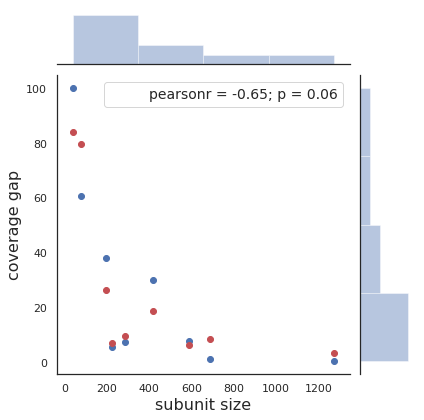

In [290]:
sns.set(rc={'axes.labelsize':16,'figure.figsize':(4,4),'legend.fontsize':14})
sns.set_style("white")
h=sns.jointplot(x='subunit size',y='coverage gap',data=look[look['mhc']=='MHC1'],stat_func=pearsonr)#.set_axis_labels('Subunit size (amino acid)','Coverage gap', fontsize=16)
h.ax_joint.scatter('subunit size','coverage gap', data=look[look['mhc']=='MHC2'], c='r')

In [210]:
tab=[]
for mth in ['MIRA peptides','all peptides']:
    for mhc in ['MHC1','MHC2']:
        pept=peptides_single[mth+'_'+mhc][vacloc['#peptide'+mhc[-1]][mth]]
        if mhc=='MHC1':
            average,det=pcs['MHC1_mhcflurry2.0-netmhc4.0-puffin-ensemble-affinity'].overall_coverage(epitopes=list(pept),lower=0,verbose=True,pre_map=True,return_pre=True,typem='mhc1_haplotype')
        else:
            average,det=pcs['MHC2_netmhc4.0-affinity'].overall_coverage(epitopes=list(pept),lower=0,verbose=True,pre_map=True,return_pre=True,typem='mhc2_haplotype')
        hist,exp=compute_probs(det)
        pr=sorted(list(objectives.loc[pept]['protein'].unique()))
        tab.append((mth,mhc,len(pept),hist['average'].loc[0],hist['average'].loc[4],hist['average'].loc[9],exp['Asians'],exp['Black'],exp['White'],','.join(pr)))

/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.


In [211]:
tab=pd.DataFrame(tab)
tab=tab.iloc[[0,2,1,3]]
tab.columns=['Candidates','MHC Class','Petide count','EvalVax-Robust (n$\geq$1)','EvalVax-Robust (n$\geq$5)','EvalVax-Robust (n$\geq$10)',\
               'Exp #peptide-HLA hits (Asian)','Exp #peptide-HLA hits (Black)','Exp #peptide-HLA hits (White)','Protein origin']
tab

,Candidates,MHC Class,Petide count,EvalVax-Robust (n$\geq$1),EvalVax-Robust (n$\geq$5),EvalVax-Robust (n$\geq$10),Exp #peptide-HLA hits (Asian),Exp #peptide-HLA hits (Black),Exp #peptide-HLA hits (White),Protein origin
0,MIRA peptides,MHC1,36,0.999969,0.998323,0.966144,22.987323,20.016993,21.957213,"M,N,ORF10,ORF1a,ORF1b,ORF3a,ORF7a,S1,S2"
2,all peptides,MHC1,31,1.000000,0.999485,0.963662,18.959121,17.025796,18.821151,"M,N,ORF10,ORF1a,ORF1b,ORF3a,S1,S2"
1,MIRA peptides,MHC2,40,0.956252,0.887964,0.819234,16.560286,26.817616,39.001237,"M,N,ORF3a,ORF7a,ORF8,S1,S2"
3,all peptides,MHC2,38,0.996912,0.990424,0.927665,19.041108,26.220305,29.402036,"M,N,ORF1a,ORF1b,ORF3a,S1,S2"


In [200]:
mhc1=objectives[objectives['epi_len'].apply(lambda x:(x>=8)and(x<=10))].index
mhc2=objectives[objectives['epi_len'].apply(lambda x:(x>=13)and(x<=25))].index

In [94]:
table=[]
for cut in [3,8,13,18,23]:
    ep=cPickle.load(open(join('optimization_result/multiobject_vaccine_adapt_norm40','beam_{}.p'.format(cut)), "rb" ))[0][0].split('_')
    average,det,pept=pc_multi.overall_multi(epitopes_long=ep,lower=4,verbose=True,pre_map=True,return_pre=True)
    pr=objectives.loc[ep]['protein'].unique()
    for mhc in ['MHC1','MHC2']:
        hist,exp=compute_probs(det[mhc][1])
        table.append((cut+1,mhc,len(pept[mhc]),hist['average'].loc[0],hist['average'].loc[4],hist['average'].loc[9],exp['Asians'],exp['Black'],exp['White'],'_'.join(pr)))

/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:127: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.


In [95]:
table3=pd.DataFrame(table)
table3.columns=['# 25mer peptide','mhc','extracted non-redundant peptide','EvalVax-Robust (n$\geq$1)','EvalVax-Robust (n$\geq$5)','EvalVax-Robust (n$\geq$10)',\
               'Exp #peptide-HLA hits (Asian)','Exp #peptide-HLA hits (Black)','Exp #peptide-HLA hits (White)','protein origin']
table3

,# 25mer peptide,mhc,extracted non-redundant peptide,EvalVax-Robust (n$\geq$1),EvalVax-Robust (n$\geq$5),EvalVax-Robust (n$\geq$10),Exp #peptide-HLA hits (Asian),Exp #peptide-HLA hits (Black),Exp #peptide-HLA hits (White),protein origin
0,4,MHC1,11,0.998435,0.646131,0.024164,5.420456,4.604432,5.933459,ORF1b_S2_S1
1,4,MHC2,16,0.987796,0.693738,0.366350,5.502930,8.246761,10.131378,ORF1b_S2_S1
2,9,MHC1,31,0.999918,0.939551,0.663579,12.901493,9.960222,11.931676,ORF1b_S1_ORF1a_S2_ORF10
3,9,MHC2,29,0.995735,0.940526,0.754764,11.407494,14.966418,17.972409,ORF1b_S1_ORF1a_S2_ORF10
4,14,MHC1,53,0.999958,0.983800,0.867290,17.501603,14.189234,16.358317,ORF1b_ORF1a_M_S1_S2
5,14,MHC2,43,0.996096,0.965577,0.866407,14.906185,20.042425,23.784539,ORF1b_ORF1a_M_S1_S2
6,19,MHC1,70,0.999992,0.995512,0.928527,22.163852,17.698794,19.730258,ORF1b_M_ORF1a_S1_S2_ORF3a
7,19,MHC2,58,0.996298,0.981820,0.907237,19.677394,25.247930,31.561575,ORF1b_M_ORF1a_S1_S2_ORF3a
8,24,MHC1,80,0.999992,0.997058,0.951973,24.721680,19.356001,21.624678,ORF1b_M_ORF1a_S1_S2_ORF3a
9,24,MHC2,67,0.996837,0.986535,0.927413,21.211035,29.457266,35.658931,ORF1b_M_ORF1a_S1_S2_ORF3a


In [97]:
def plot_hist2(hist_detail,axs,title=''):
    #f,axs=plt.subplots(1,len(hist_detail),figsize=(3.5*len(hist_detail),2.5))
    for j,cntry in enumerate(hist_detail):
        hist=hist_detail[cntry][1]
        axs[j].bar(hist['count'].values,hist['freq'].values,width=1,color='lightblue')
        if cntry=='Asians':
            axs[j].set_title('Asian'+' '+title,fontsize=13)
        else:
            axs[j].set_title(cntry+' '+title,fontsize=13)
        axs[j].set_xlabel('# peptide-HLA hits',fontsize=13)
        axs[j].set_ylabel('frequency',fontsize=13)
        exp=(hist['count']*hist['freq']).sum()
        axs[j].axvline(x=exp,c='lightcoral',ls='--',lw=2,label='$\mathbb{E}(\# hits)$')
        axs[j].legend(fontsize=12)
        print cntry,exp
    plt.tight_layout()

def plot_coverage(det,name,axes,lower_bound,cv):
    hist_all={'White':[],'Black':[],'Asian':[]}
    for cnty in det:
        hist=det[cnty][1]
        for cut in range(8):
            if cnty=='Asians':
                hist_all['Asian'].append(hist[hist['count']>cut]['freq'].sum())
            else:
                hist_all[cnty].append(hist[hist['count']>cut]['freq'].sum())
    hist_all=pd.DataFrame(hist_all)
    hist_all['average']=hist_all.mean(axis=1)
    hist_all.index=hist_all.index.rename('min_cutoff')
    display(hist_all)
    new_hist={'Population coverage%':[],'ethnic':[],'min #peptide cutoff':[]}
    for cl in hist_all.columns:
        new_hist['Population coverage%']=new_hist['Population coverage%']+list(hist_all[cl].values*100)
        new_hist['ethnic']=new_hist['ethnic']+([cl]*len(hist_all))
        new_hist['min #peptide cutoff']=new_hist['min #peptide cutoff']+[('$n\geq{}$'.format(x+1)) for x in hist_all.index]
    new_hist=pd.DataFrame(new_hist)
    with sns.color_palette("Set2"):
        ax = sns.barplot(x="min #peptide cutoff", y='Population coverage%', hue="ethnic", data=new_hist,ax=axes)
        ax.legend(loc=3,fontsize=13)
        ax.set_xlabel('min #peptide-HLA hits cutoff',fontsize=13)
        ax.set_ylabel('Population coverage (%)',fontsize=13)
        plt.tight_layout()
        ax.set_title('{} population coverage p($n\geq{}$)={:.2f}%'.format(name,lower_bound+1,cv*100))

def plot_detail3(model,epitopes,pc,lower_bound=0,name='OptiVax(Ours)',suffix='',\
                 pal="husl",size=(19,6),lgd=False,processed='(binarized)'):
    average,det,pept=pc.overall_multi(epitopes_long=epitopes,lower=lower_bound,verbose=True,pre_map=True,return_pre=True)
    print det['MHC1'][0],det['MHC2'][0],average
    f1,axs1 = plt.subplots(2, 4,figsize=size,gridspec_kw={'width_ratios': [1,1.2,1.2,1.2]})#,constrained_layout=True)
    plot_coverage(det['MHC1'][1],'MHC1',axs1[0][0],lower_bound,det['MHC1'][0])
    with sns.color_palette("Set2"):
        plot_hist2(det['MHC1'][1],axs=axs1[0][1:])
    plot_coverage(det['MHC2'][1],'MHC2',axs1[1][0],lower_bound,det['MHC2'][0])
    with sns.color_palette("Set2"):
        plot_hist2(det['MHC2'][1],axs=axs1[1][1:])
    plt.tight_layout()
    plt.show()
    f1.savefig(join('Joint_vaccine_detail{}.png'.format(suffix)),dpi=300,bbox_inches = "tight")
    f1.savefig(join('Joint_vaccine_detail{}.pdf'.format(suffix)),dpi=300,bbox_inches = "tight")

/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:46: PerformanceWarning: indexing past lexsort depth may impact performance.
/data/gl/g4/geliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:127: PerformanceWarning: indexing past lexsort depth may impact performance.


0.998682932591 0.990267335239 0.994475133915


,Asian,Black,White,average
min_cutoff,,,,
0,1.000000,0.999984,1.000000,0.999995
1,1.000000,0.999902,0.999999,0.999967
2,0.999999,0.999709,0.999997,0.999902
3,0.999999,0.998074,0.999989,0.999354
4,0.999998,0.996163,0.999888,0.998683
5,0.999878,0.992637,0.999766,0.997427
6,0.999770,0.986183,0.999389,0.995114
7,0.999484,0.979224,0.998467,0.992392


White 28.775007946
Black 25.7880461211
Asians 33.2309344755


,Asian,Black,White,average
min_cutoff,,,,
0,0.991160,0.999463,0.999888,0.996837
1,0.988828,0.997594,0.999706,0.995376
2,0.980197,0.997265,0.999563,0.992342
3,0.978593,0.996703,0.999460,0.991585
4,0.976112,0.995661,0.999029,0.990267
5,0.959190,0.989467,0.998750,0.982469
6,0.954499,0.984587,0.998582,0.979223
7,0.935920,0.983335,0.998297,0.972517


White 43.2748391358
Black 34.5584242741
Asians 25.8539550766


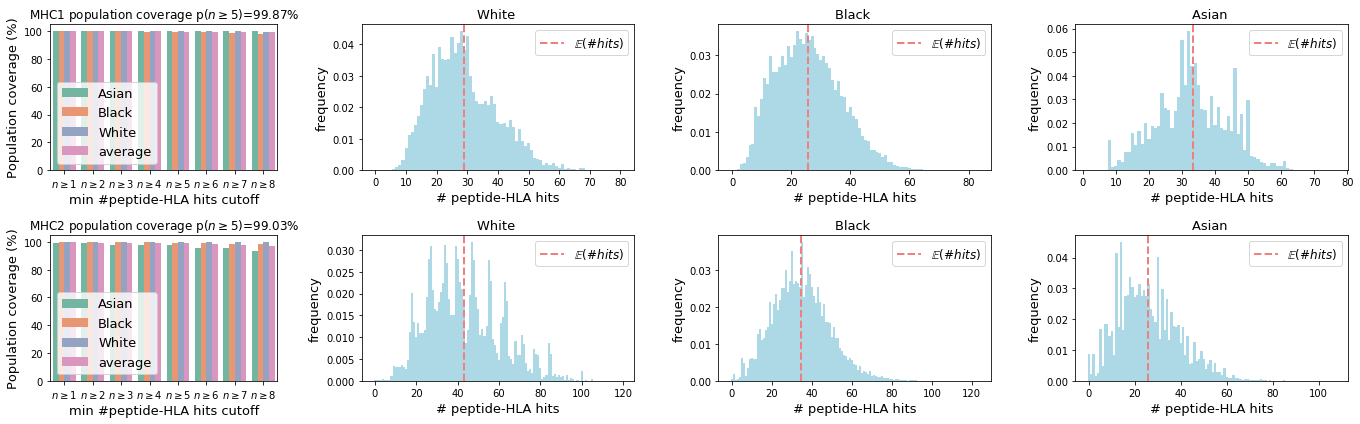

In [99]:
ep=cPickle.load(open(join('optimization_result/multiobject_vaccine_adapt_norm40','beam_32.p'), "rb" ))[0][0].split('_')
plot_detail3({'MHC1':dss['MHC1_mhcflurry2.0-netmhc4.0-puffin-ensemble-affinity'],'MHC2':dss['MHC2_netmhc4.0-affinity']},ep,pc_multi,lower_bound=4,suffix='33')

In [177]:
peptides_single={}
peptides_single['MIRA peptides_MHC1']=peptides_vaccine2['adaptive_mhc1']
peptides_single['MIRA peptides_MHC2']=peptides_vaccine2['adaptive_mhc2']
peptides_single['all peptides_MHC1']=peptides_vaccine2['all_mhc1']
peptides_single['all peptides_MHC2']=peptides_vaccine2['all_mhc2']

In [180]:
base=[]
for sub in peptides_single:
    base.append(vac2[(vac2['num. augment peptides'].apply(lambda x:x in [0,vacloc['#peptide'+sub[-1]][sub.split('_')[0]]]))&(vac2['subunit']==sub.split('_')[0])&(vac2['mhc']==sub.split('_')[1])])
base=pd.concat(base,axis=0).pivot_table(values='population', index=['cutoff','mhc','subunit'], columns=['ethnic','task'])
basecover=base.loc['#hits$\leq$7'][('Average','compress')]

In [184]:
basecover['MHC1','design']=1.0
basecover['MHC2','design']=1.0

In [187]:
compcurve={}
subs=['all peptides','design']
compcurve['De novo vaccine design']=[]
range1=1.0
range2=1.0
cuts=zip(np.arange(range1,0,(0-range1)/25.0),np.arange(range2,0,(0-range2)/25.0))
for x,y in cuts:
    x=x
    y=y
    f1=findloc(curve_multi,1-x,1-y,subs=['design']).loc['design']
    f2=findloc_single(vac2,1-x,1-y,subs=['all peptides']).loc['all peptides']
    budget1=f1['#peptide']*25+(f1['#peptide']-1)*10
    budget2=len(''.join(peptides_single['all peptides_MHC1'][f2['#peptide1']]))+len(''.join(peptides_single['all peptides_MHC2'][f2['#peptide2']]))+10*(f2['#peptide1']+f2['#peptide2']-1)
    compcurve['De novo vaccine design'].append((budget1,f1['cutoff1']*100.0,'Joint','MHC1'))
    compcurve['De novo vaccine design'].append((budget1,f1['cutoff2']*100.0,'Joint','MHC2'))
    compcurve['De novo vaccine design'].append((budget2,f2['cutoff1']*100.0,'Separate','MHC1'))
    compcurve['De novo vaccine design'].append((budget2,f2['cutoff2']*100.0,'Separate','MHC2'))
compcurve['De novo vaccine design'].append((0,(1-basecover.loc['MHC1','design'])*100.0,'Joint','MHC1'))
compcurve['De novo vaccine design'].append((0,(1-basecover.loc['MHC2','design'])*100.0,'Joint','MHC2'))
compcurve['De novo vaccine design'].append((0,(1-basecover.loc['MHC1','design'])*100.0,'Separate','MHC1'))
compcurve['De novo vaccine design'].append((0,(1-basecover.loc['MHC2','design'])*100.0,'Separate','MHC2'))
compcurve['De novo vaccine design']=pd.DataFrame(compcurve['De novo vaccine design'])
compcurve['De novo vaccine design'].columns=['num. amino acid','Population coverage(%)','Optimization','MHC class']

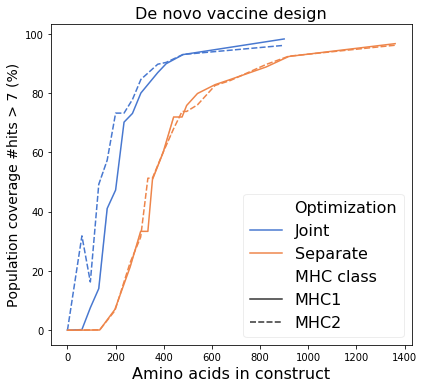

In [195]:
f,axs=plt.subplots(1,1,figsize=(6,5.5))
count=0
for sub in ['De novo vaccine design']:
    i=0
    with sns.color_palette("muted"):
        ax = sns.lineplot(x="num. amino acid", y="Population coverage(%)",hue='Optimization',style='MHC class',data=compcurve[sub],ax=axs)
        ax.set_xlabel('Amino acids in construct',fontsize=16)
        ax.set_ylabel('Population coverage #hits > 7 (%)',fontsize=14)
        ax.set_title('De novo vaccine design',fontsize=16)
        ax.legend(framealpha=0.35,fontsize=16)
        #ax.get_legend().remove()
    count+=1
plt.tight_layout()
plt.show()

In [196]:
compcurve={}
subs=['all peptides','design']
compcurve['De novo vaccine design']=[]
range1=1.0
range2=1.0
cuts=zip(np.arange(range1,0,(0-range1)/25.0),np.arange(range2,0,(0-range2)/25.0))
for x,y in cuts:
    x=x
    y=y
    f1=findloc(curve_multi,1-x,1-y,subs=['design']).loc['design']
    f2=findloc_single(vac2,1-x,1-y,subs=['all peptides']).loc['all peptides']
    #budget1=f1['#peptide']*25+(f1['#peptide']-1)*10
    #budget2=len(''.join(peptides_single['all peptides_MHC1'][f2['#peptide1']]))+len(''.join(peptides_single['all peptides_MHC2'][f2['#peptide2']]))+10*(f2['#peptide1']+f2['#peptide2']-1)
    budget1=f1['#peptide']
    budget2=len(peptides_single['all peptides_MHC1'][f2['#peptide1']])+len(peptides_single['all peptides_MHC2'][f2['#peptide2']])
    compcurve['De novo vaccine design'].append((budget1,f1['cutoff1']*100.0,'Joint','MHC1'))
    compcurve['De novo vaccine design'].append((budget1,f1['cutoff2']*100.0,'Joint','MHC2'))
    compcurve['De novo vaccine design'].append((budget2,f2['cutoff1']*100.0,'Separate','MHC1'))
    compcurve['De novo vaccine design'].append((budget2,f2['cutoff2']*100.0,'Separate','MHC2'))
compcurve['De novo vaccine design'].append((0,(1-basecover.loc['MHC1','design'])*100.0,'Joint','MHC1'))
compcurve['De novo vaccine design'].append((0,(1-basecover.loc['MHC2','design'])*100.0,'Joint','MHC2'))
compcurve['De novo vaccine design'].append((0,(1-basecover.loc['MHC1','design'])*100.0,'Separate','MHC1'))
compcurve['De novo vaccine design'].append((0,(1-basecover.loc['MHC2','design'])*100.0,'Separate','MHC2'))
compcurve['De novo vaccine design']=pd.DataFrame(compcurve['De novo vaccine design'])
compcurve['De novo vaccine design'].columns=['num. peptides','Population coverage(%)','Optimization','MHC class']

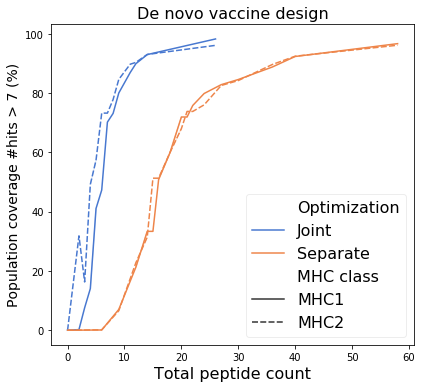

In [197]:
f,axs=plt.subplots(1,1,figsize=(6,5.5))
count=0
for sub in ['De novo vaccine design']:
    i=0
    with sns.color_palette("muted"):
        ax = sns.lineplot(x="num. peptides", y="Population coverage(%)",hue='Optimization',style='MHC class',data=compcurve[sub],ax=axs)
        ax.set_xlabel('Total peptide count',fontsize=16)
        ax.set_ylabel('Population coverage #hits > 7 (%)',fontsize=14)
        ax.set_title('De novo vaccine design',fontsize=16)
        ax.legend(framealpha=0.35,fontsize=16)
        #ax.get_legend().remove()
    count+=1
plt.tight_layout()
plt.show()